<a href="https://colab.research.google.com/github/khairav/MachinLearning-Mini_Project/blob/main/Fraud_Detection_IEE_E_CIS_Rapids%2C_CatBoost_and_LGBM_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Penipuan XGB dengan skor Ajaib LB 0,96
Model ini adalah bagian dari solusi tempat pertama untuk kompetisi "IEEE-CIS Fraud Detection" Kaggle. Saat model ini digabungkan dengan model CatBoost dan LGBM Konstantin, hasilnya mencapai LB publik 0,9677 dan LB pribadi 0,9459 menempati posisi pertama di sini

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Run the following code to provide the config path to kaggle.json

In [15]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
#changing the working directory
%cd /content/drive/MyDrive/Kaggle
!ls

/content/drive/MyDrive/Kaggle
kaggle.json


In [16]:
!kaggle competitions download -c ieee-fraud-detection

  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 33.2MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 104MB/s]
 84% 49.0M/58.3M [00:00<00:00, 114MB/s]
100% 58.3M/58.3M [00:00<00:00, 119MB/s]
 75% 39.0M/52.2M [00:00<00:00, 125MB/s]
100% 52.2M/52.2M [00:00<00:00, 132MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 52.4MB/s]


In [17]:
os.listdir()

['kaggle.json',
 'sample_submission.csv.zip',
 'train_identity.csv.zip',
 'train_transaction.csv.zip',
 'test_transaction.csv.zip',
 'test_identity.csv.zip']

In [18]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      

Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   

Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       

5 archives were successfully processed.


In [19]:
%cd /content/drive/MyDrive/Kaggle/IEE-Fraud-Detection

/content/drive/MyDrive/Kaggle/IEE-Fraud-Detection


In [20]:
#import Library
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

# import Dataset IEE

In [21]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 31 s, sys: 2.92 s, total: 33.9 s
Wall time: 36.7 s


In [23]:
cols_t = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']
cols_v = ['V'+str(x) for x in range(1,340)]; types_v = {}
for c in cols_v: types_v[c] = 'float32'
train = pd.read_csv('train_transaction.csv',usecols=cols_t+['isFraud']+cols_v,dtype=types_v)


In [24]:
train.head()

TransactionID  isFraud  TransactionDT  ...  V337 V338  V339
0        2987000        0          86400  ...   NaN  NaN   NaN
1        2987001        0          86401  ...   NaN  NaN   NaN
2        2987002        0          86469  ...   NaN  NaN   NaN
3        2987003        0          86499  ...   NaN  NaN   NaN
4        2987004        0          86506  ...   0.0  0.0   0.0

[5 rows x 394 columns]

#Check Missing Na

In [26]:
nans_df = train.isna()
nans_groups={}
i_cols = ['V'+str(i) for i in range(1,340)]
for col in train.columns:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
            nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

for k,v in nans_groups.items():
    print('####### NAN count =',k)
    print(v)

####### NAN count = 0
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
####### NAN count = 8933
['card2']
####### NAN count = 1565
['card3']
####### NAN count = 1577
['card4']
####### NAN count = 4259
['card5']
####### NAN count = 1571
['card6']
####### NAN count = 65706
['addr1', 'addr2']
####### NAN count = 352271
['dist1']
####### NAN count = 552913
['dist2']
####### NAN count = 94456
['P_emaildomain']
####### NAN count = 453249
['R_emaildomain']
####### NAN count = 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
####### NAN count = 280797
['D2']
####### NAN count = 262878
['D3']
####### NAN count = 168922
['D4']
####### NAN count = 309841
['D5']
####### NAN count = 517353
['D6']
####### NAN count = 551623
['D7']
####### NAN count = 515614
['D8', 'D9']
####### NAN count = 76022
['D10']
####### NAN count = 27

In [29]:
Vc = ['dayr','isFraud','TransactionAmt','card1','addr1','D1n','D11n']
Vs = nans_groups[279287]
Vtitle = 'V1 - V11, D11'

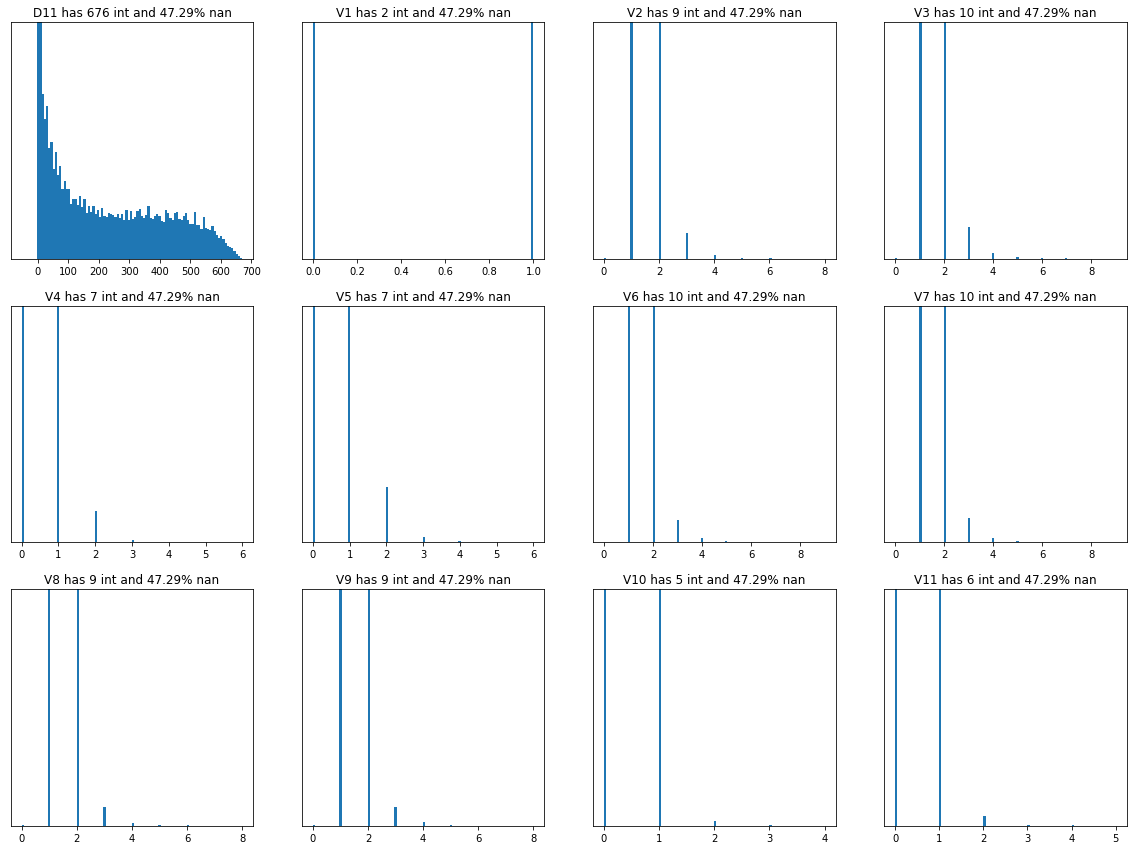

In [30]:
def make_plots(Vs):
    col = 4
    row = len(Vs)//4+1
    plt.figure(figsize=(20,row*5))
    idx = train[~train[Vs[0]].isna()].index
    for i,v in enumerate(Vs):
        plt.subplot(row,col,i+1)
        n = train[v].nunique()
        x = np.sum(train.loc[idx,v]!=train.loc[idx,v].astype(int))
        y = np.round(100*np.sum(train[v].isna())/len(train),2)
        t = 'int'
        if x!=0: t = 'float'
        plt.title(v+' has '+str(n)+' '+t+' and '+str(y)+'% nan')
        plt.yticks([])
        h = plt.hist(train.loc[idx,v],bins=100)
        if len(h[0])>1: plt.ylim((0,np.sort(h[0])[-2]))
    plt.show()
make_plots(Vs)

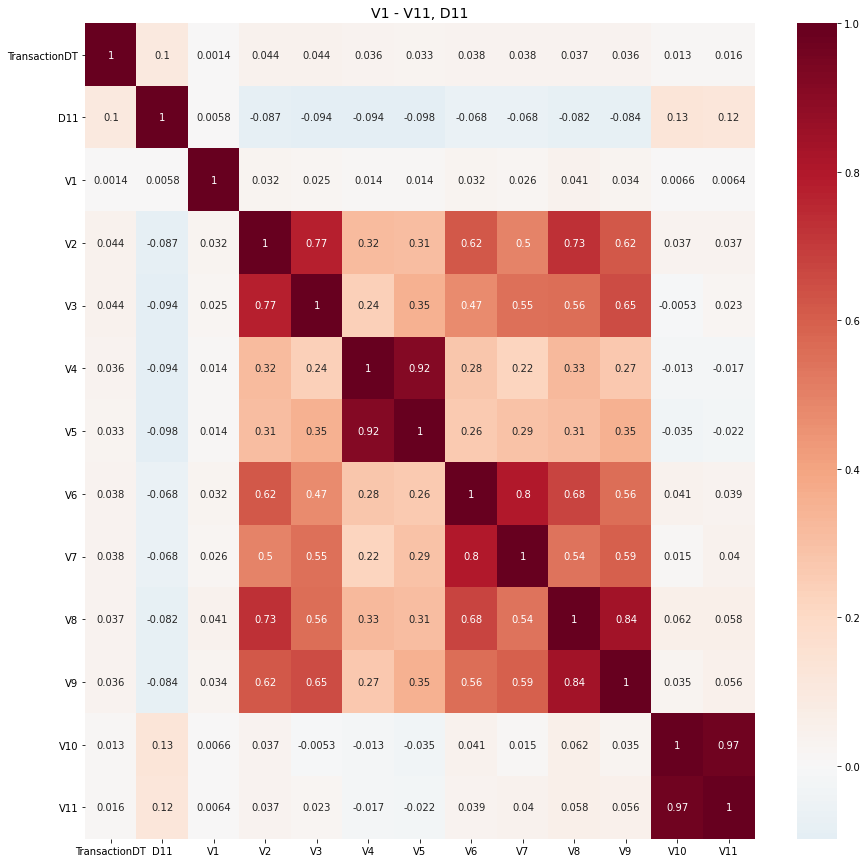

In [31]:
def make_corr(Vs,Vtitle=''):
    cols = ['TransactionDT'] + Vs
    plt.figure(figsize=(15,15))
    sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle!='': plt.title(Vtitle,fontsize=14)
    else: plt.title(Vs[0]+' - '+Vs[-1],fontsize=14)
    plt.show()
make_corr(Vs,Vtitle)

In [32]:
grps = [[1],[2,3],[4,5],[6,7],[8,9],[10,11]]
def reduce_group(grps,c='V'):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = train[c+str(gg)].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
reduce_group(grps)

Use these [1, 3, 4, 6, 8, 11]


**V12 - V34**

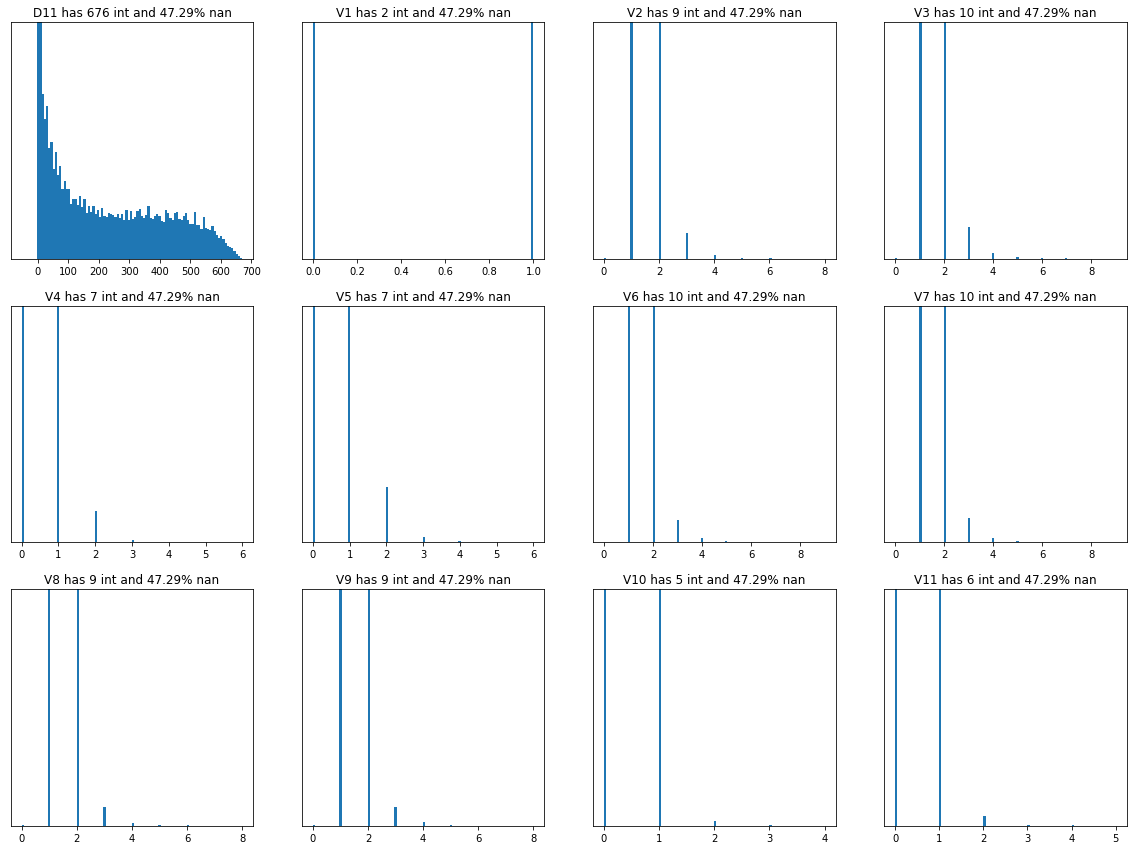

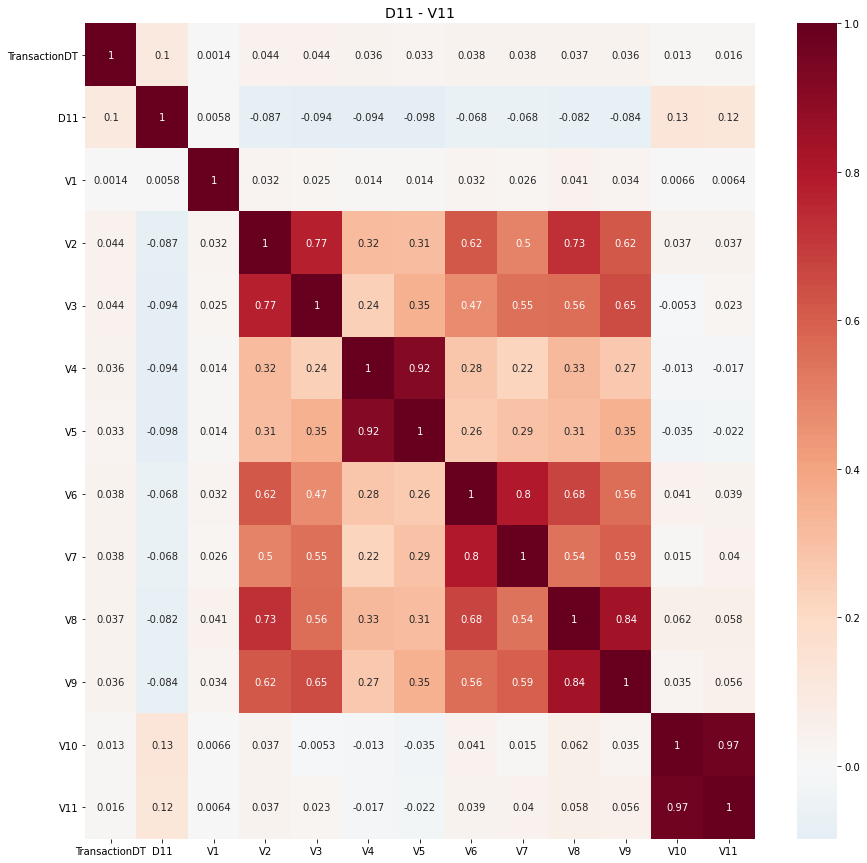

In [33]:
vs = nans_groups[76073]
make_plots(Vs)
make_corr(Vs)

In [34]:
grps = [[12,13],[14],[15,16,17,18,21,22,31,32,33,34],[19,20],[23,24],[25,26],[27,28],[29,30]]
reduce_group(grps)

Use these [13, 14, 17, 20, 23, 26, 27, 30]


**V35 - V52**

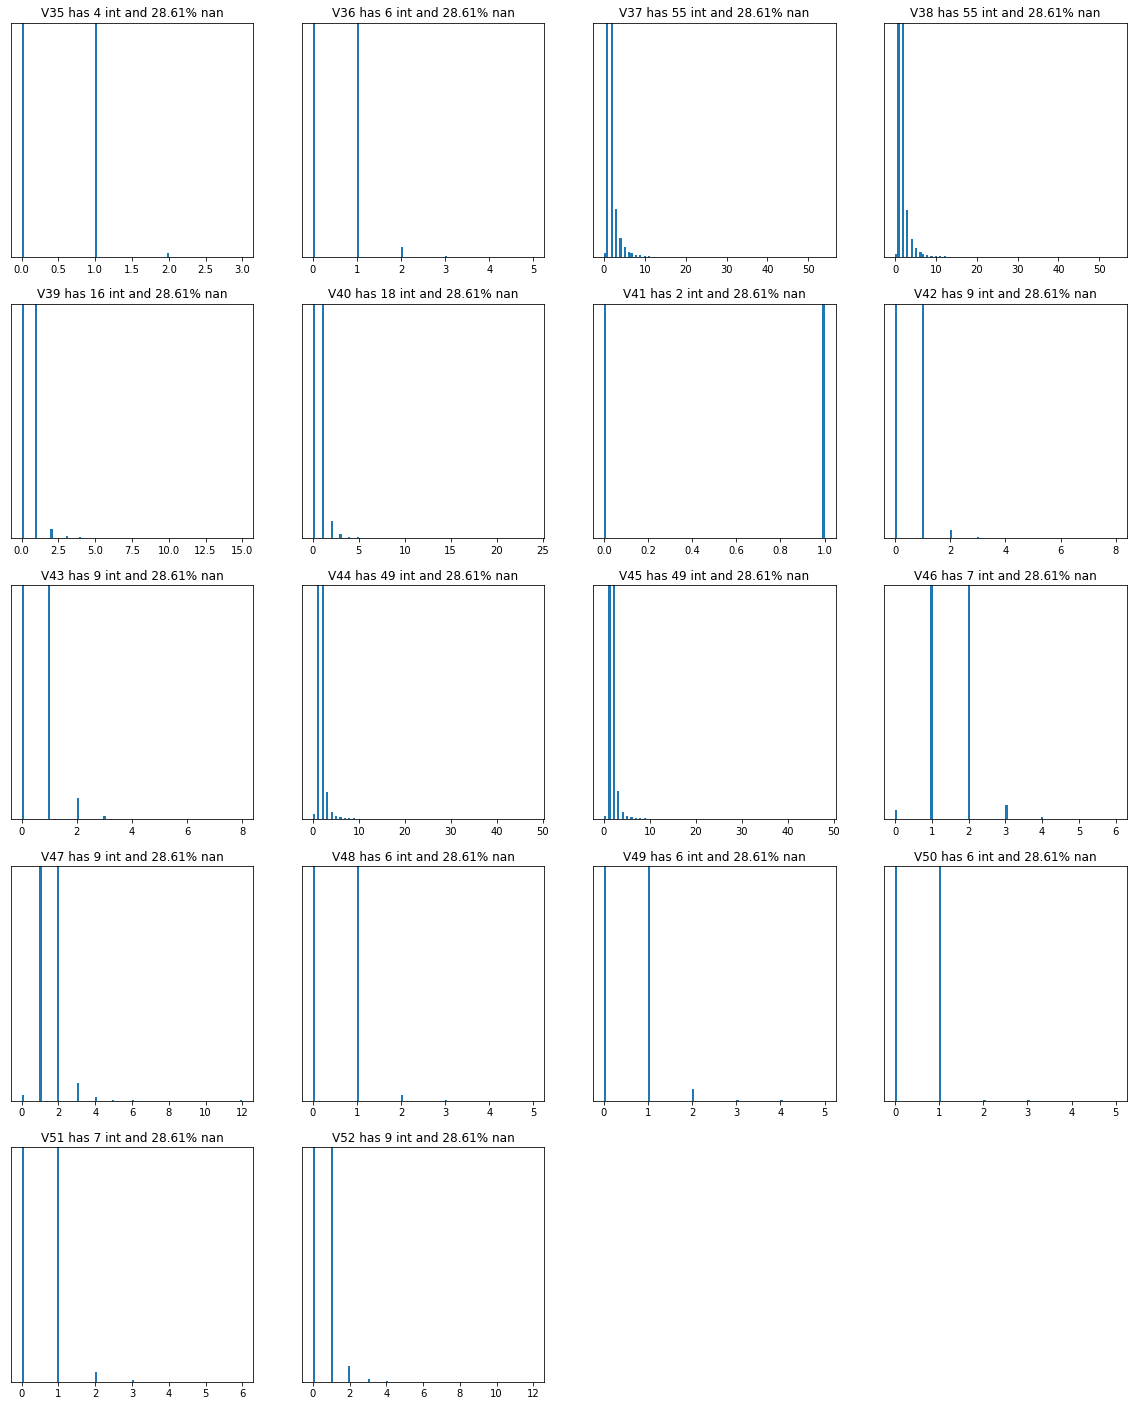

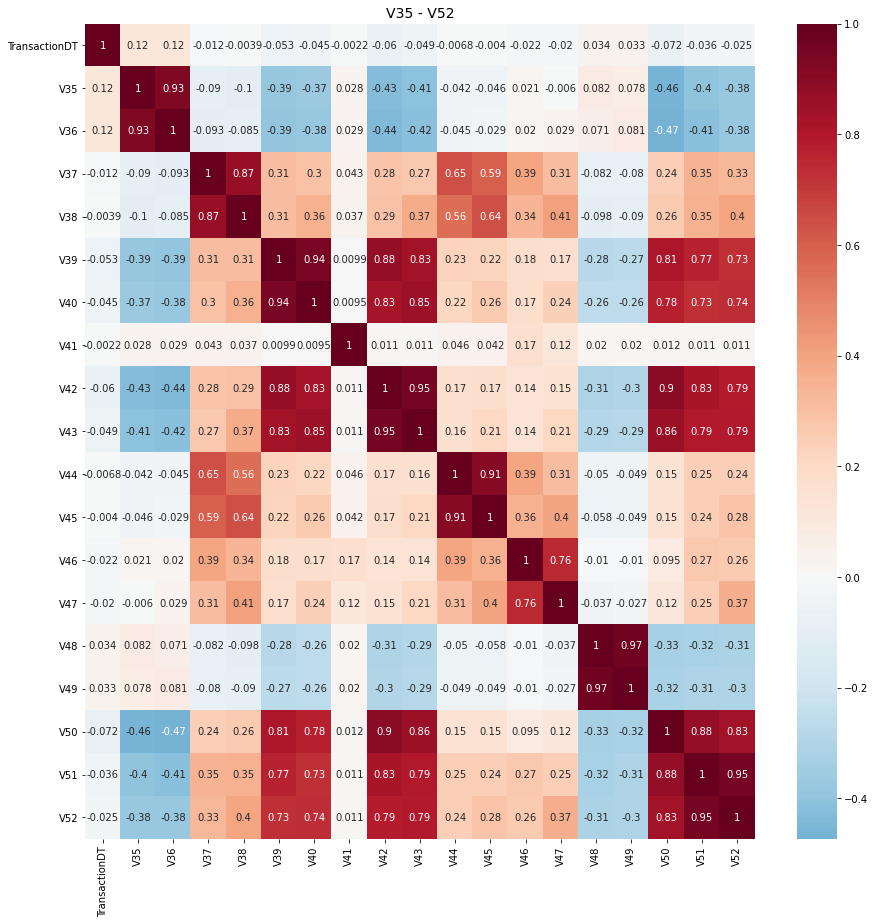

In [35]:
Vs = nans_groups[168969]
make_plots(Vs)
make_corr(Vs)

In [36]:
grps = [[35,36],[37,38],[39,40,42,43,50,51,52],[41],[44,45],[46,47],[48,49]]
reduce_group(grps)

Use these [36, 37, 40, 41, 44, 47, 48]


**V53 - V74**

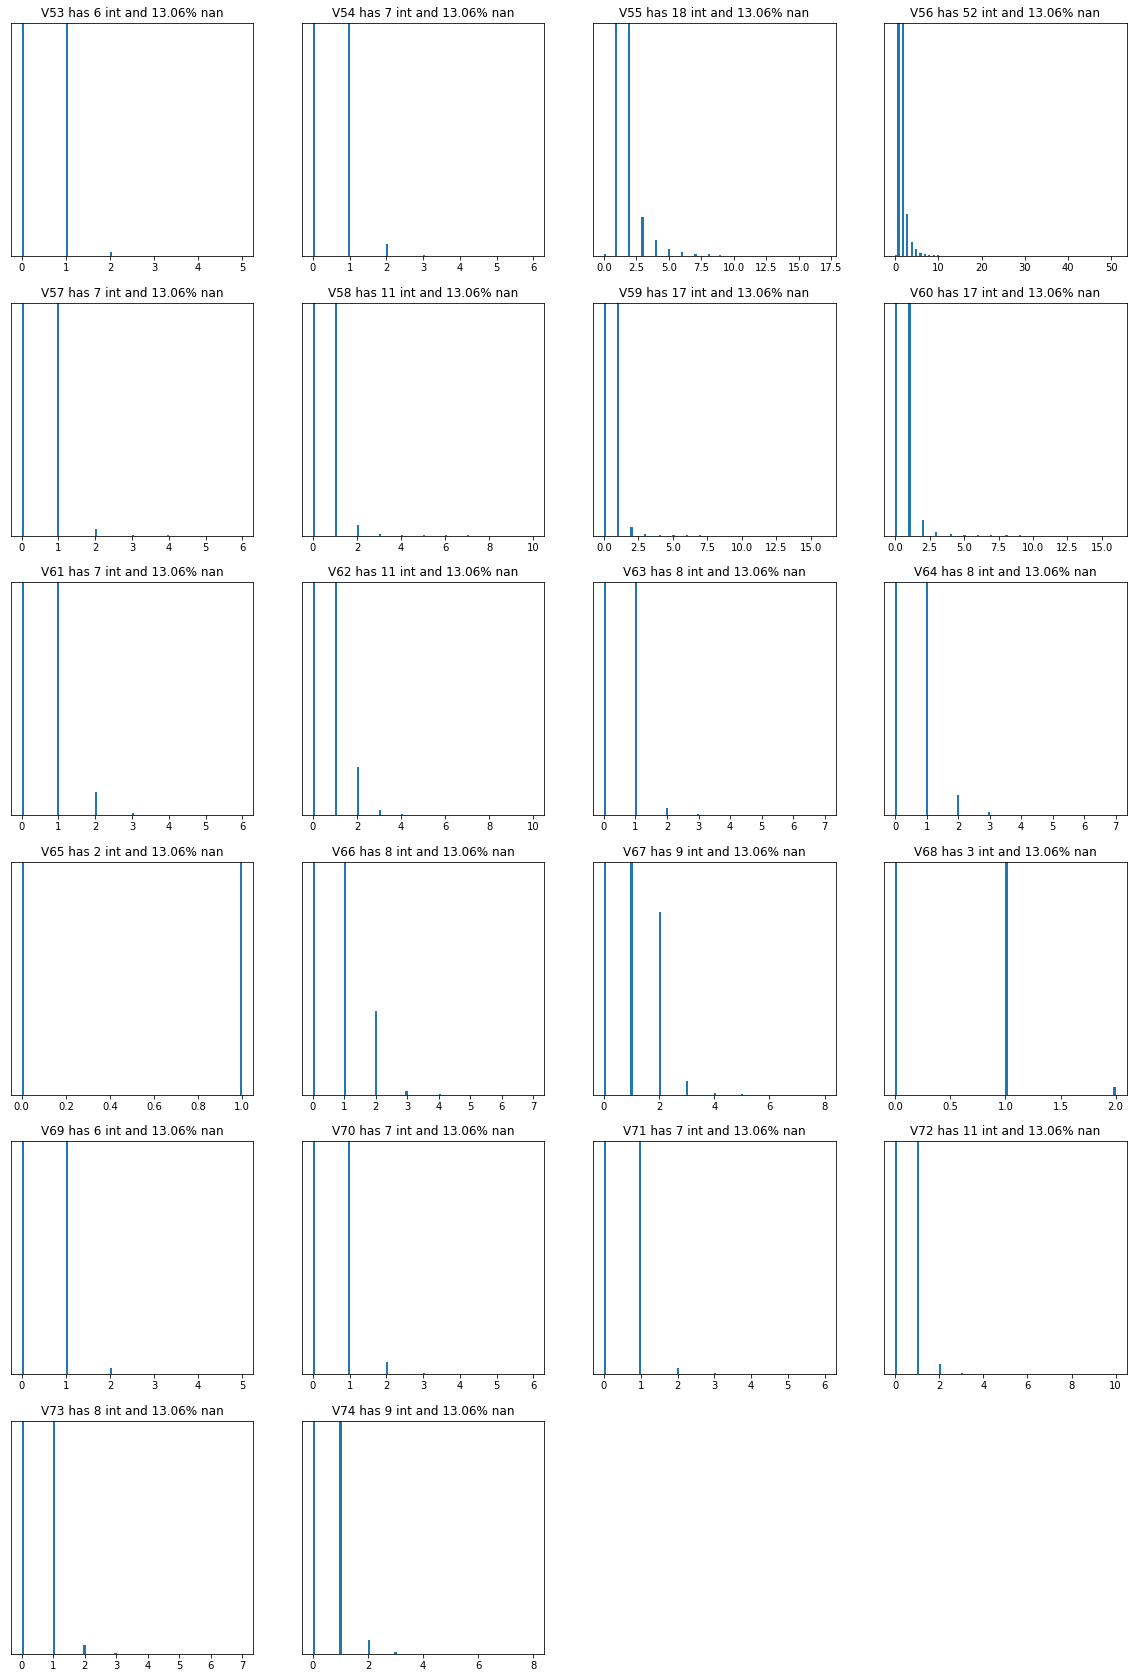

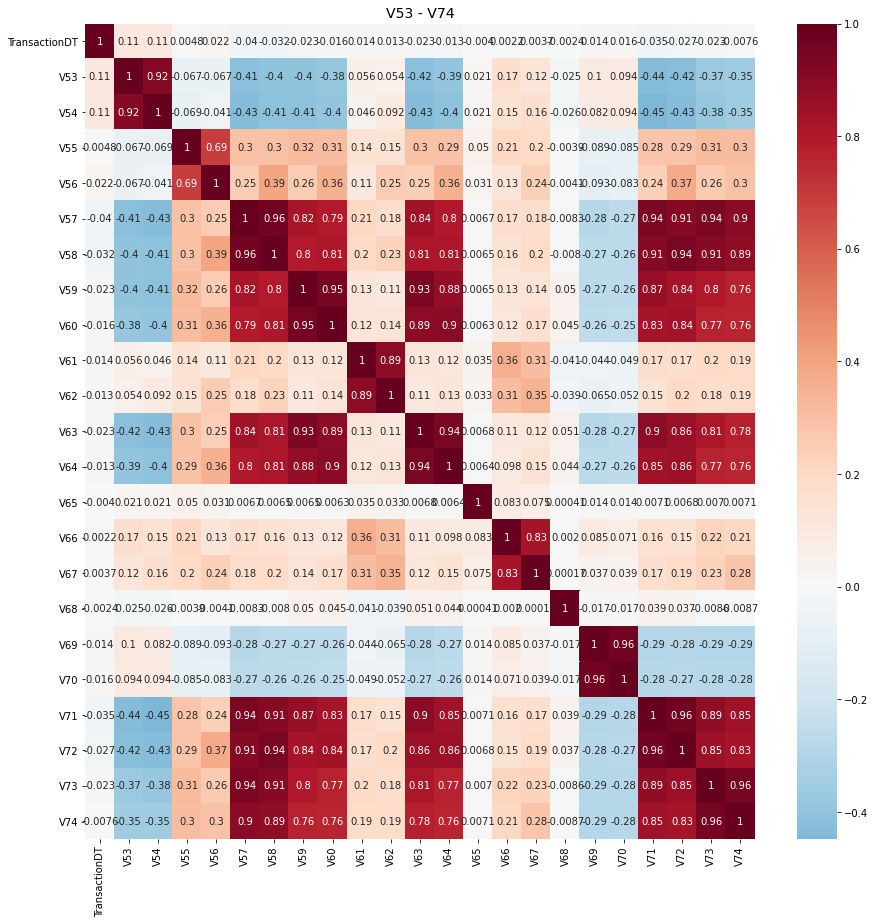

In [37]:
Vs = nans_groups[77096]
make_plots(Vs)
make_corr(Vs)

In [39]:
grps = [[75,76],[77,78],[79,80,81,84,85,92,93,94],[82,83],[86,87],[88],[89],[90,91]]
reduce_group(grps)

Use these [76, 78, 80, 82, 86, 88, 89, 91]


**V95 - V137**

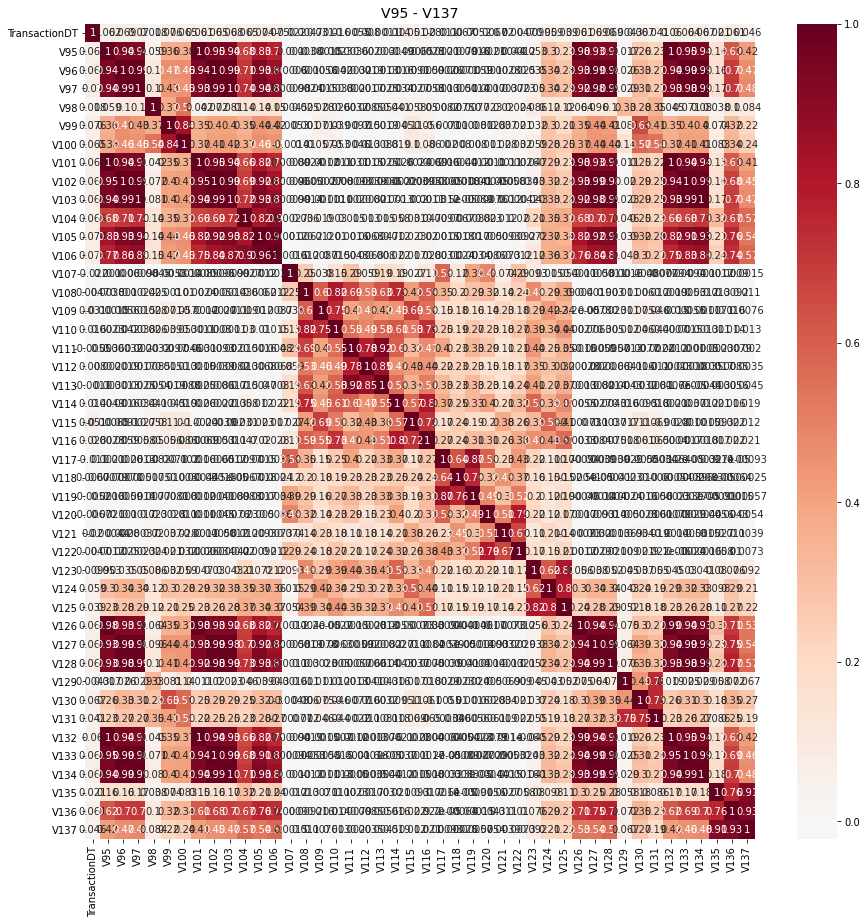

In [40]:
Vs = nans_groups[314]
make_corr(Vs)

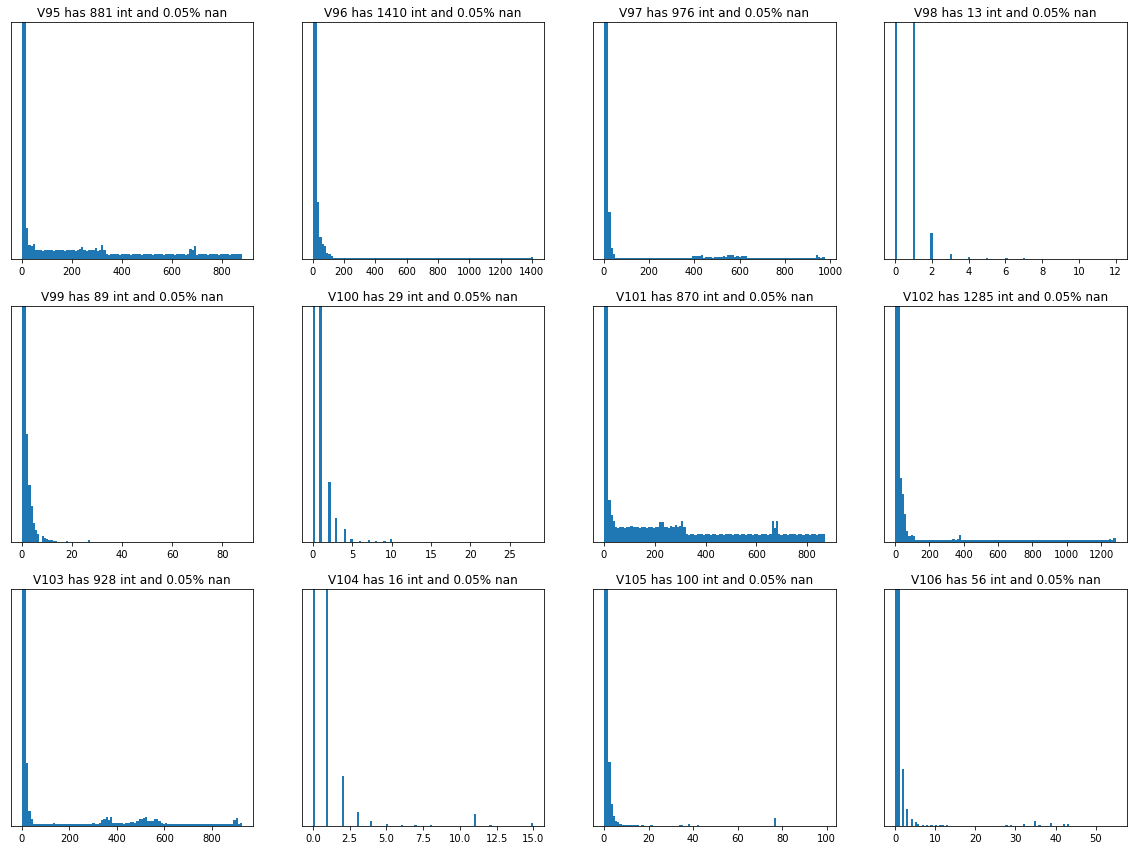

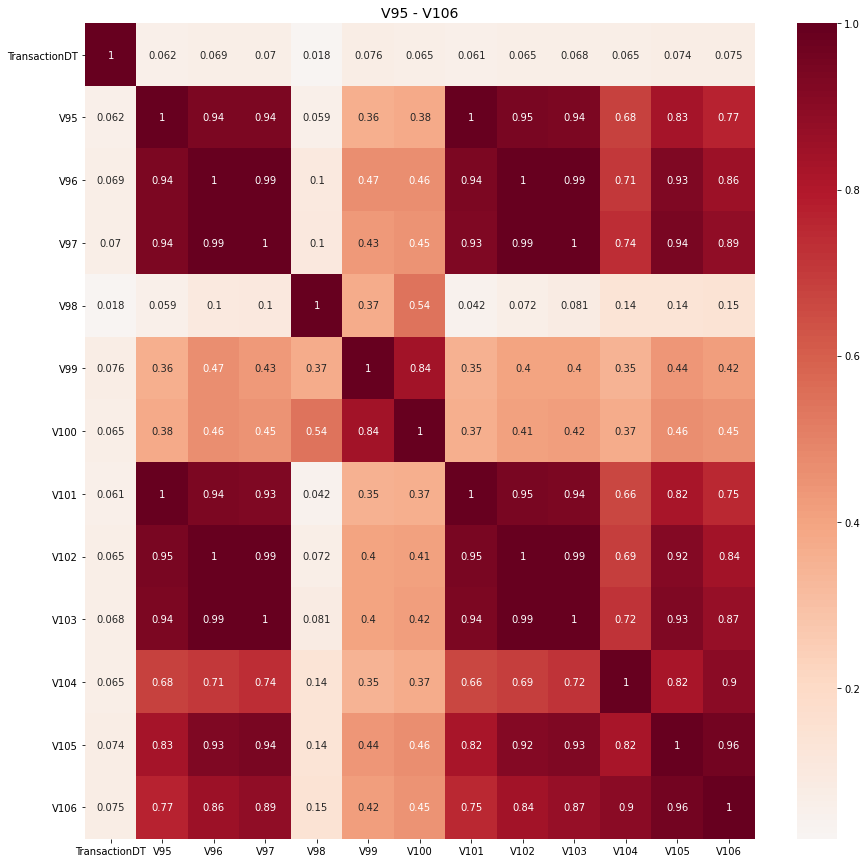

In [41]:
Vs = ['V'+str(x) for x in range(95,107)]
make_plots(Vs)
make_corr(Vs)

In [42]:
grps = [[95,96,97,101,102,103,105,106],[98],[99,100],[104]]
reduce_group(grps)

Use these [96, 98, 99, 104]


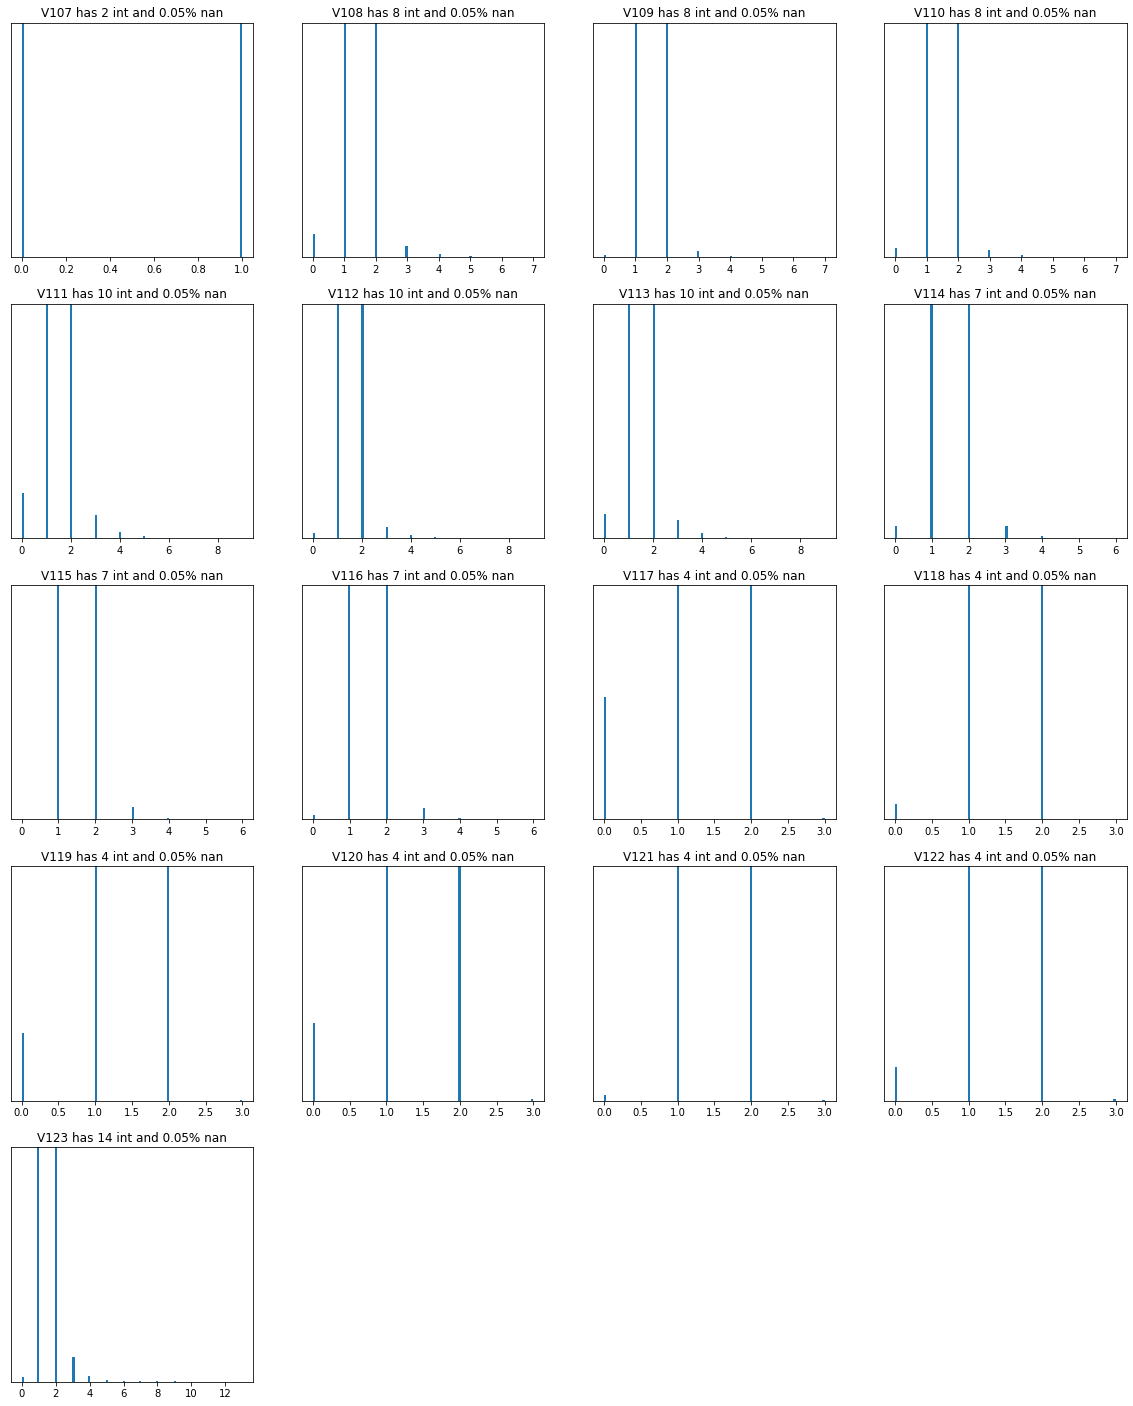

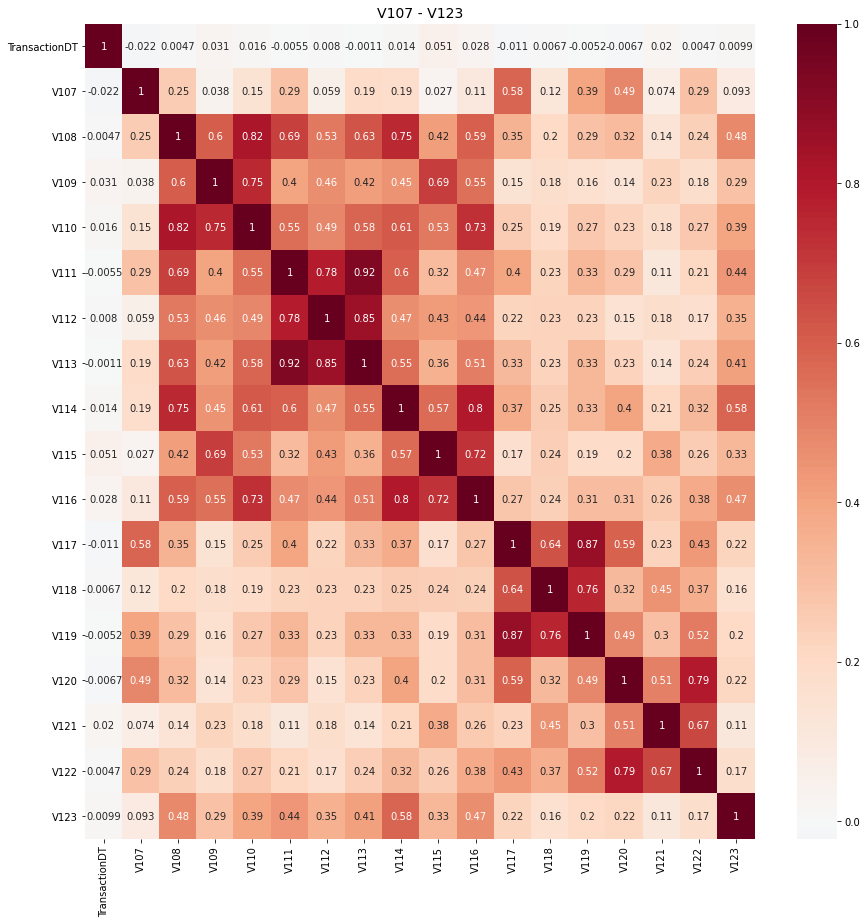

In [43]:
Vs = ['V'+str(x) for x in range(107,124)]
make_plots(Vs)
make_corr(Vs)

In [44]:
grps = [[107],[108,109,110,114],[111,112,113],[115,116],[117,118,119],[120,122],[121],[123]]
reduce_group(grps)

Use these [107, 108, 111, 115, 117, 120, 121, 123]


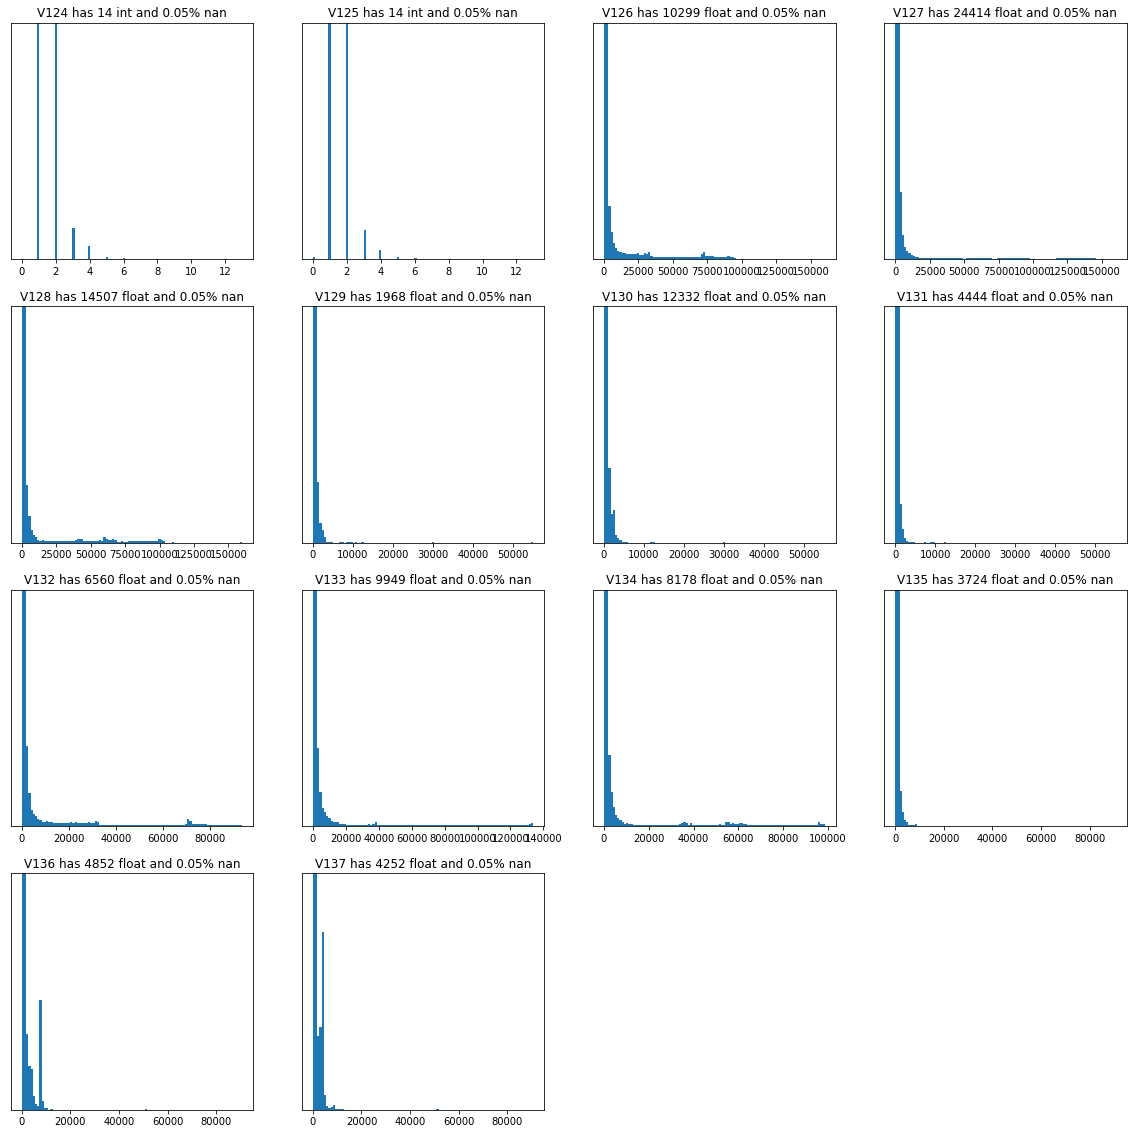

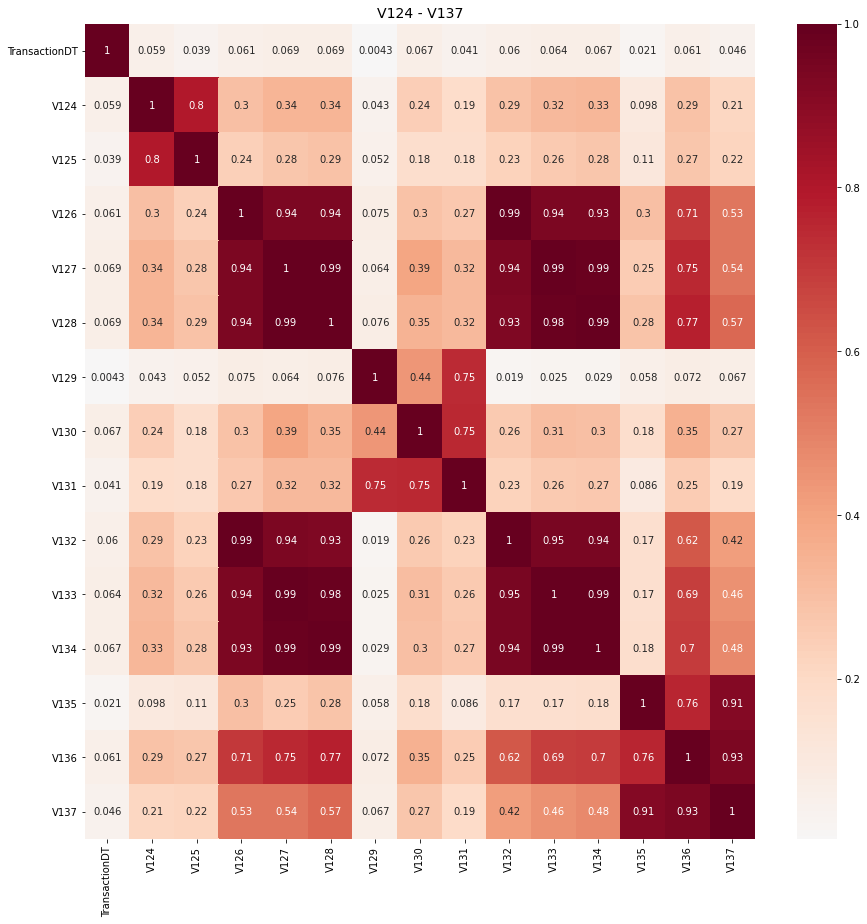

In [45]:
Vs = ['V'+str(x) for x in range(124,138)]
make_plots(Vs)
make_corr(Vs)

In [46]:
grps = [[124,125],[126,127,128,132,133,134],[129],[130,131],[135,136,137]]
reduce_group(grps)

Use these [124, 127, 129, 130, 136]


**V138 ~ V163¶**

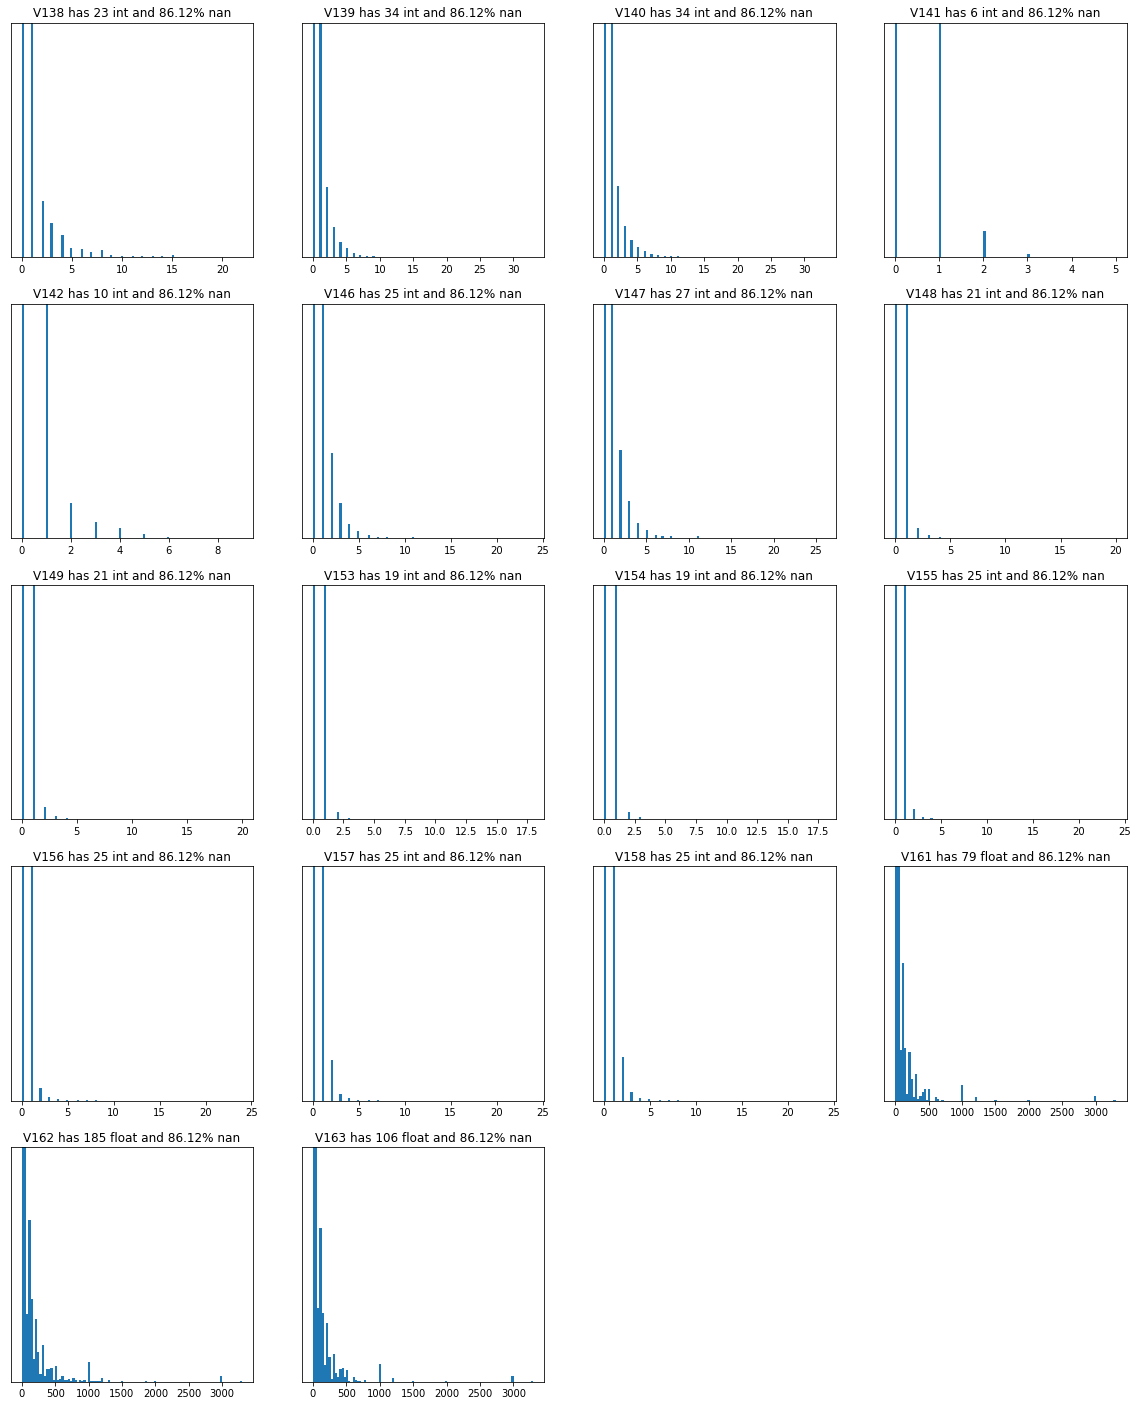

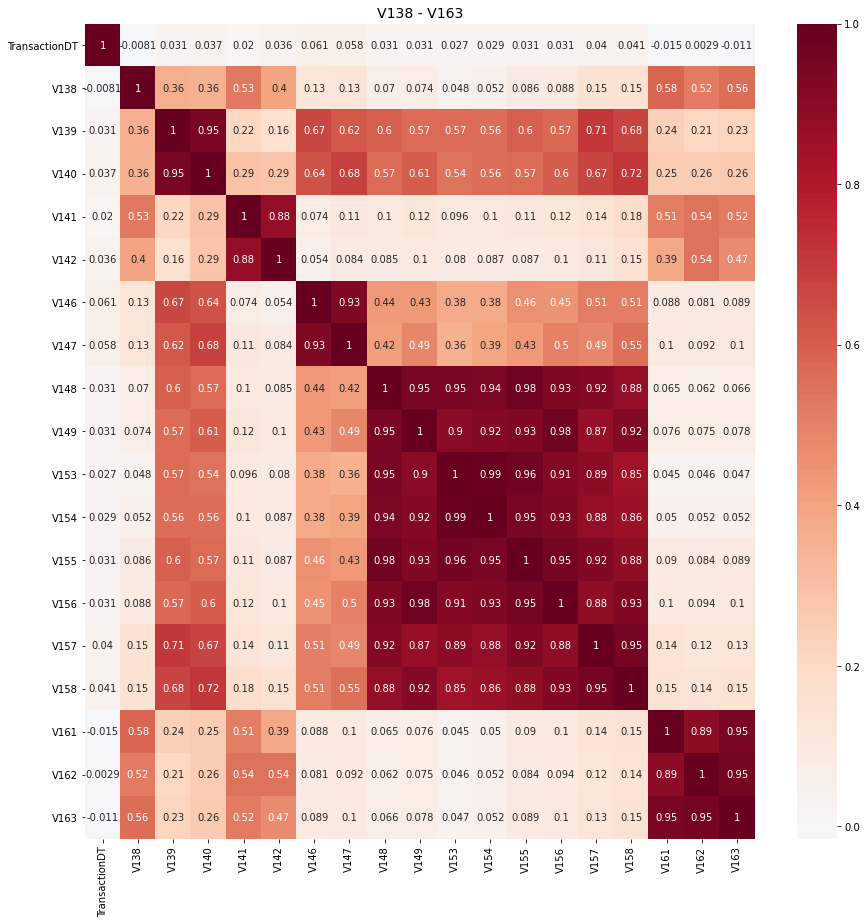

In [47]:
Vs = nans_groups[508595]
make_plots(Vs)
make_corr(Vs)

In [48]:
grps = [[138],[139,140],[141,142],[146,147],[148,149,153,154,156,157,158],[161,162,163]]
reduce_group(grps)

Use these [138, 139, 142, 147, 156, 162]


**V143 ~ V166**

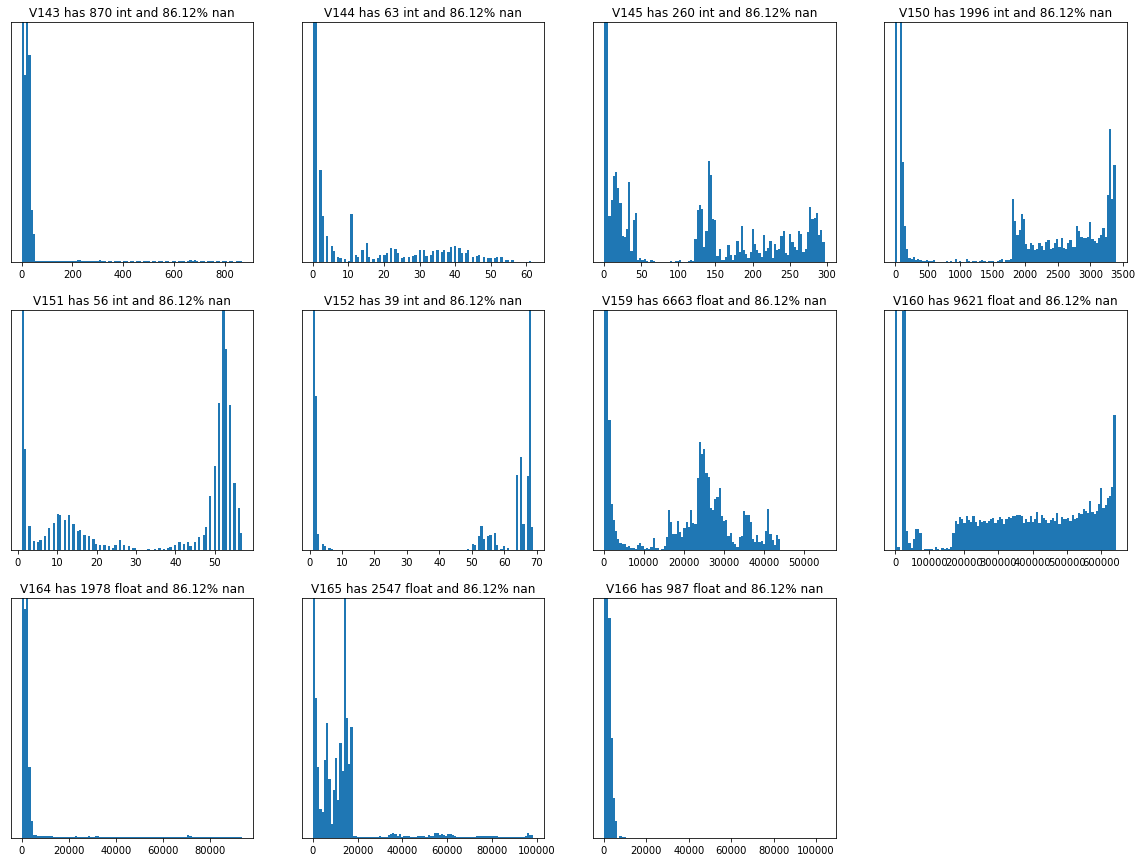

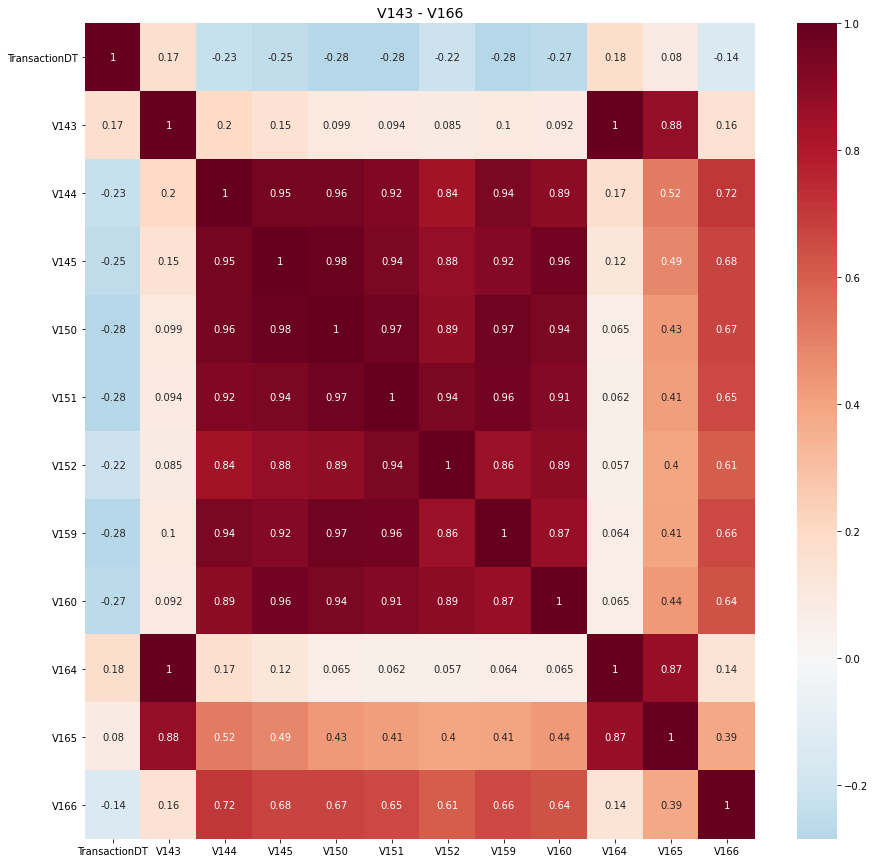

In [49]:
Vs = nans_groups[508589]
make_plots(Vs)
make_corr(Vs)

In [50]:
grps = [[143,164,165],[144,145,150,151,152,159,160],[166]]
reduce_group(grps)

Use these [165, 160, 166]


**V167 ~ V216**

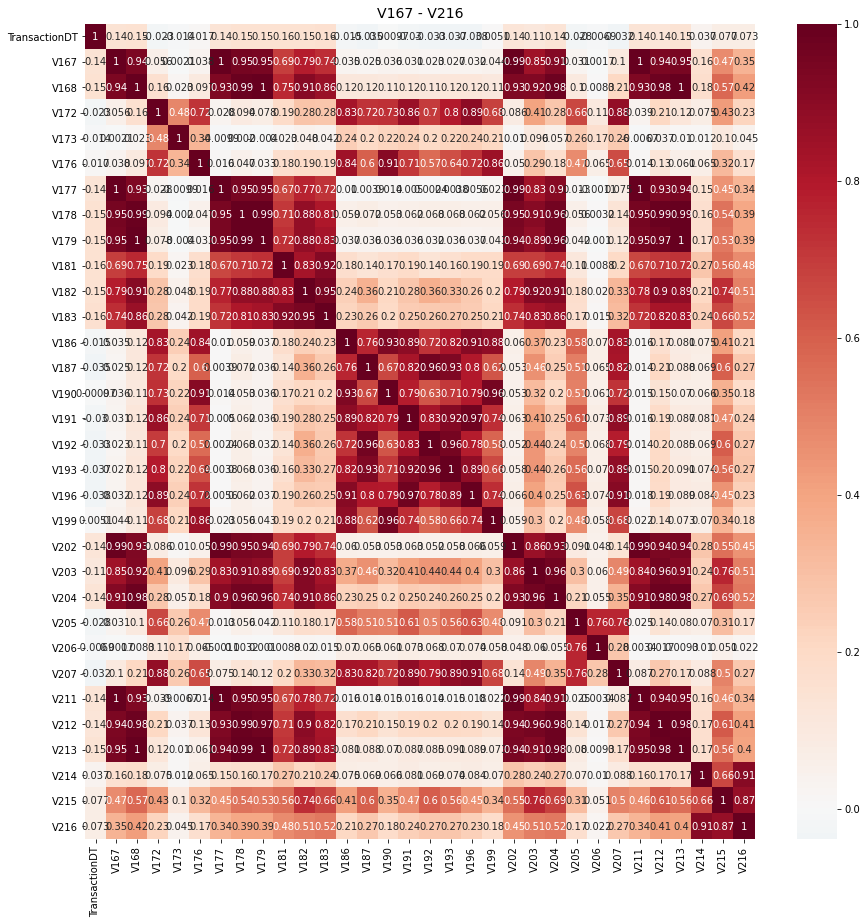

In [51]:
vs = [x for x in nans_groups[450909]]
make_corr(vs)

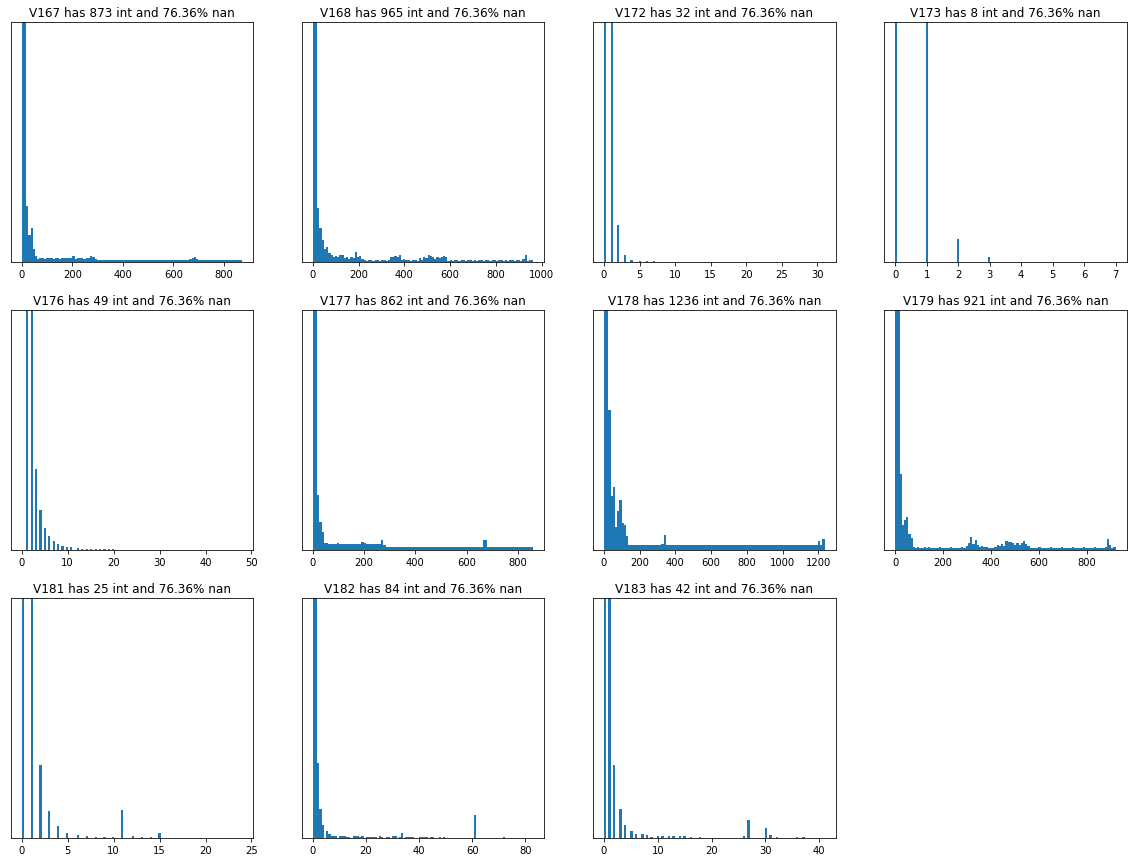

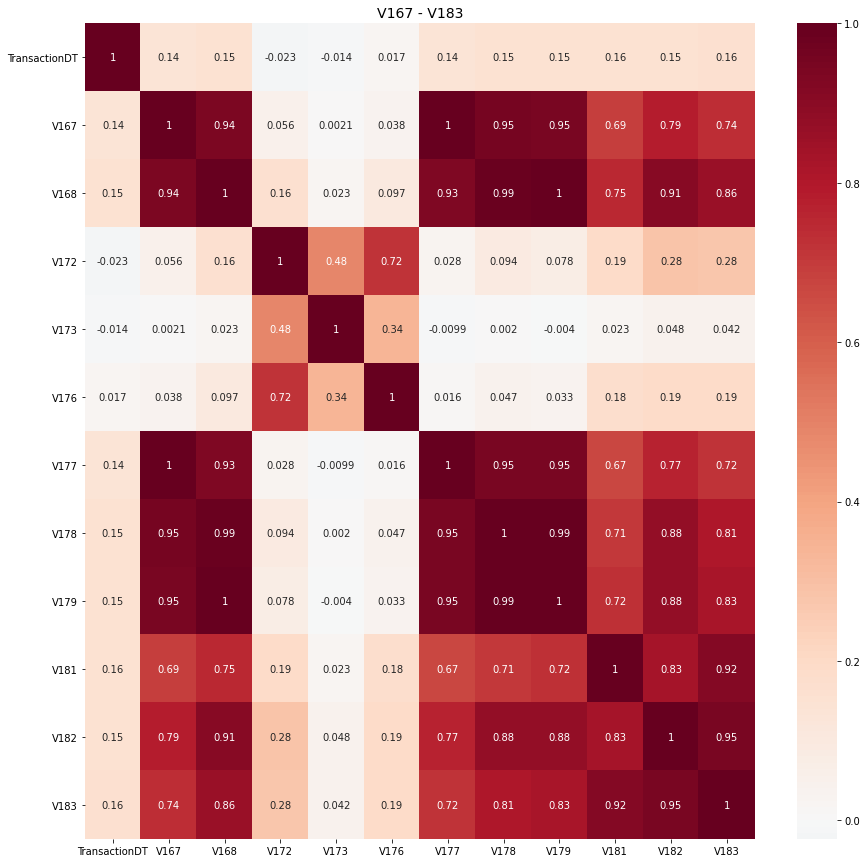

In [52]:
Vs = [x for x in nans_groups[450909] if int(x[1:])<186]
make_plots(Vs)
make_corr(Vs)

In [53]:
grps = [[167,168,177,178,179],[172,176],[173],[181,182,183]]
reduce_group(grps)

Use these [178, 176, 173, 182]


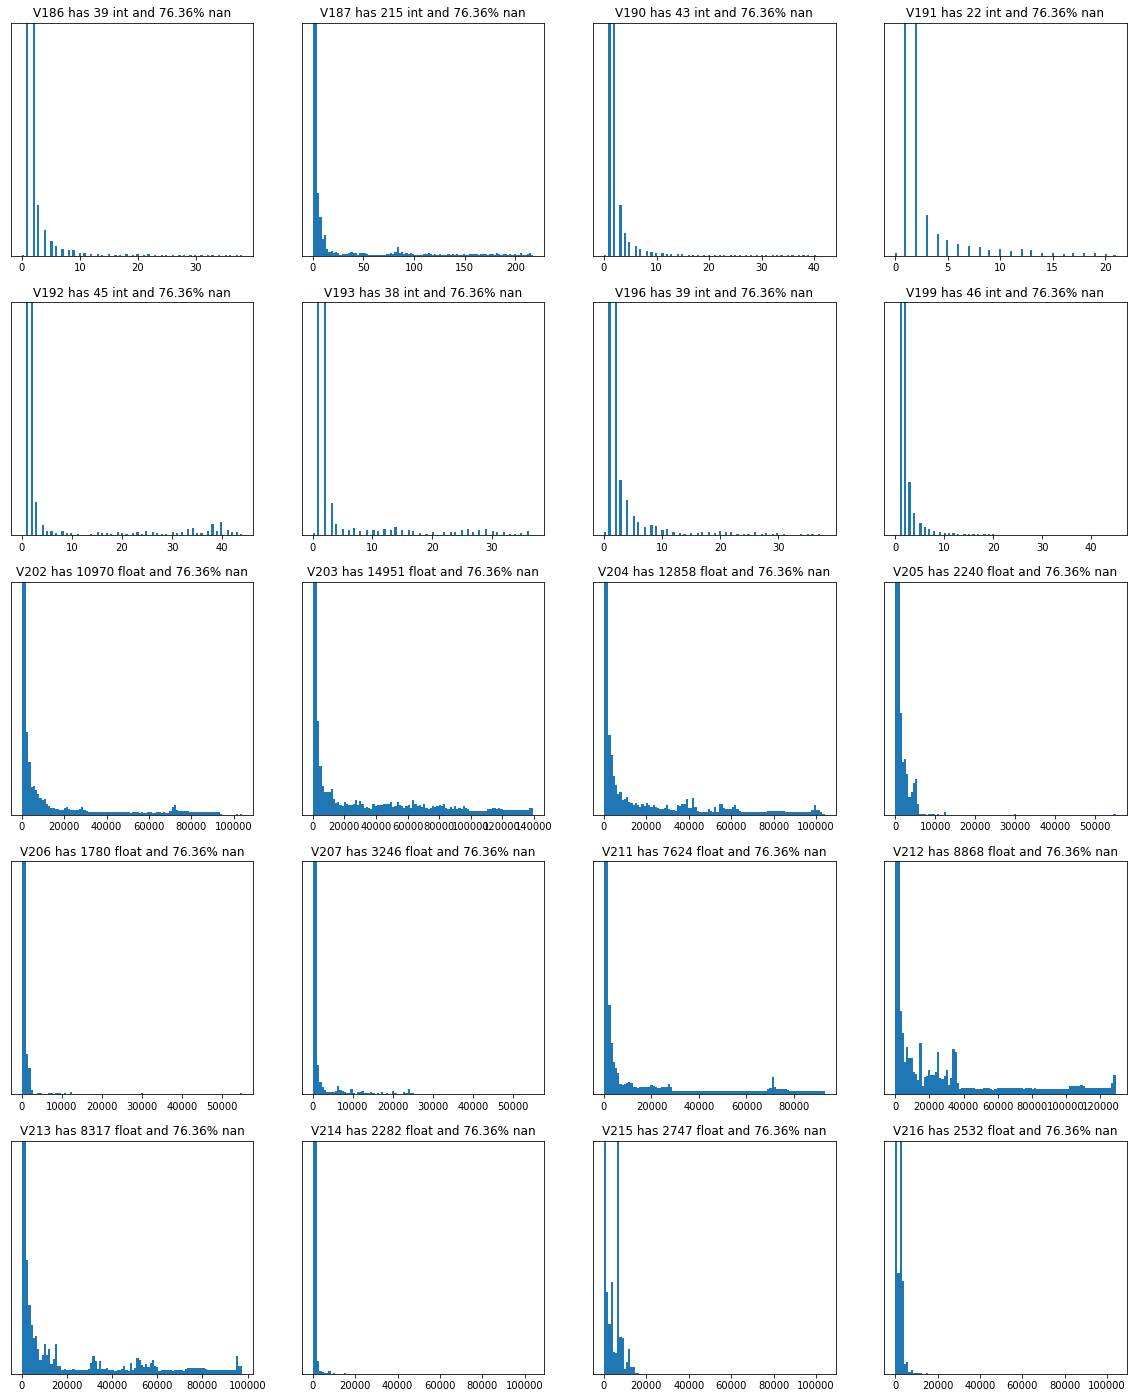

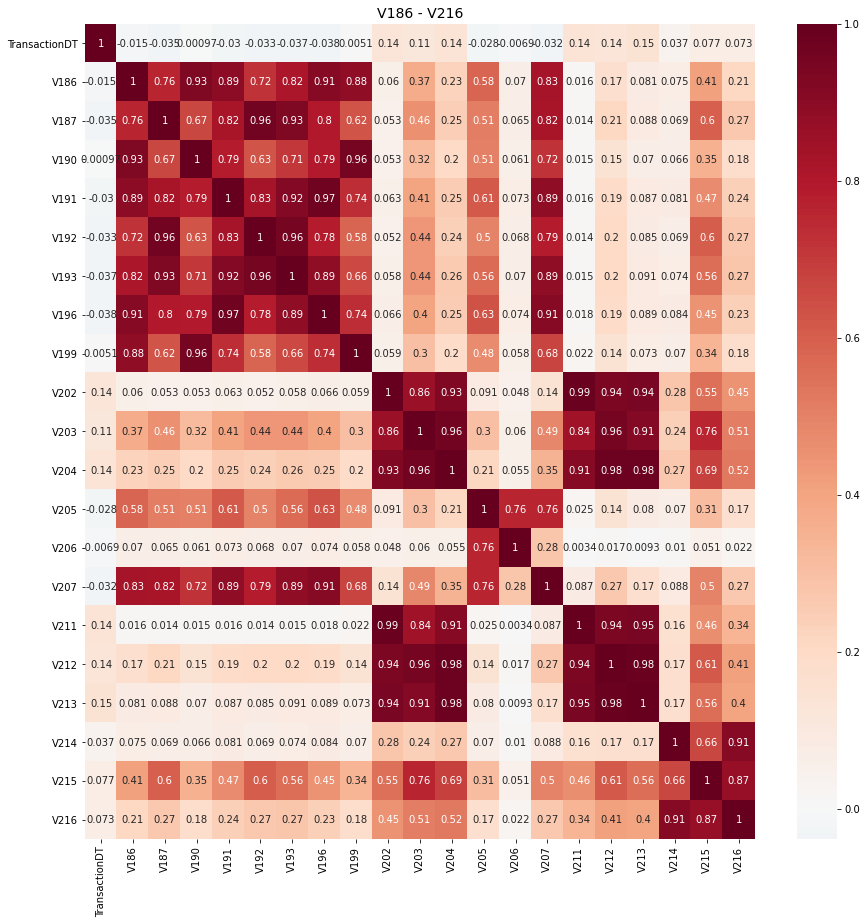

In [54]:
Vs = [x for x in nans_groups[450909] if (int(x[1:])>183)]
make_plots(Vs)
make_corr(Vs)

In [55]:
grps = [[186,187,190,191,192,193,196,199],[202,203,204,211,212,213],[205,206],[207],[214,215,216]]
reduce_group(grps)

Use these [187, 203, 205, 207, 215]


**V169 ~ V210**

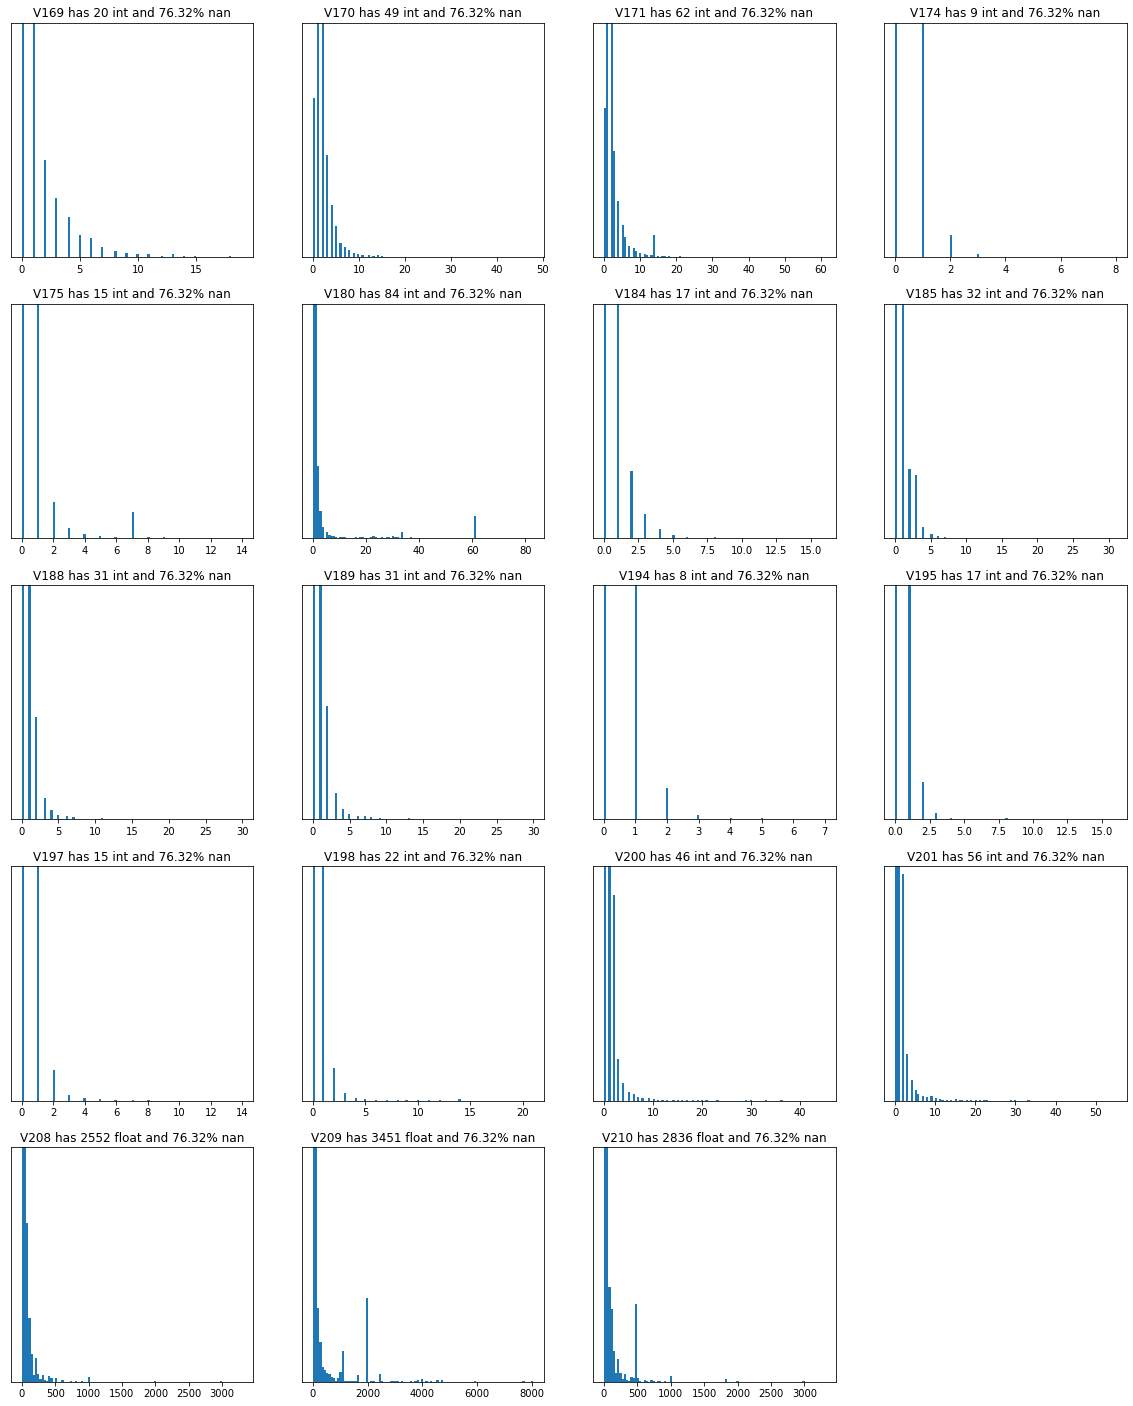

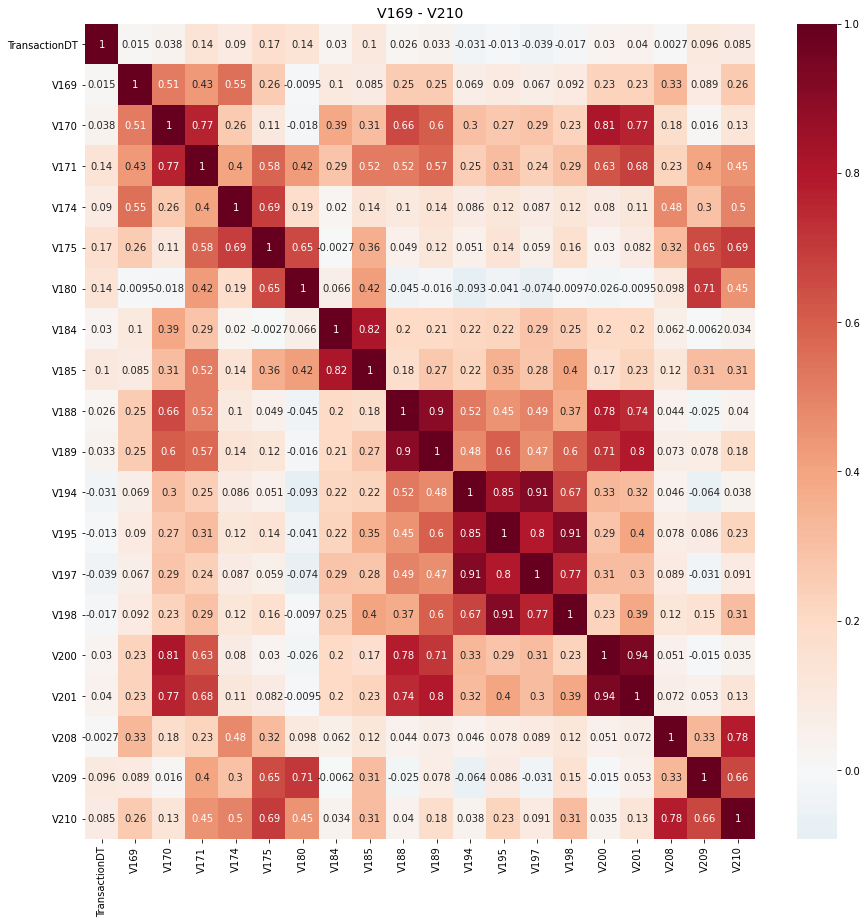

In [56]:
Vs = nans_groups[450721]
make_plots(Vs)
make_corr(Vs)

In [57]:
grps = [[169],[170,171,200,201],[174,175],[180],[184,185],[188,189],[194,195,197,198],[208,210],[209]]
reduce_group(grps)

Use these [169, 171, 175, 180, 185, 188, 198, 210, 209]


**V217-V278**

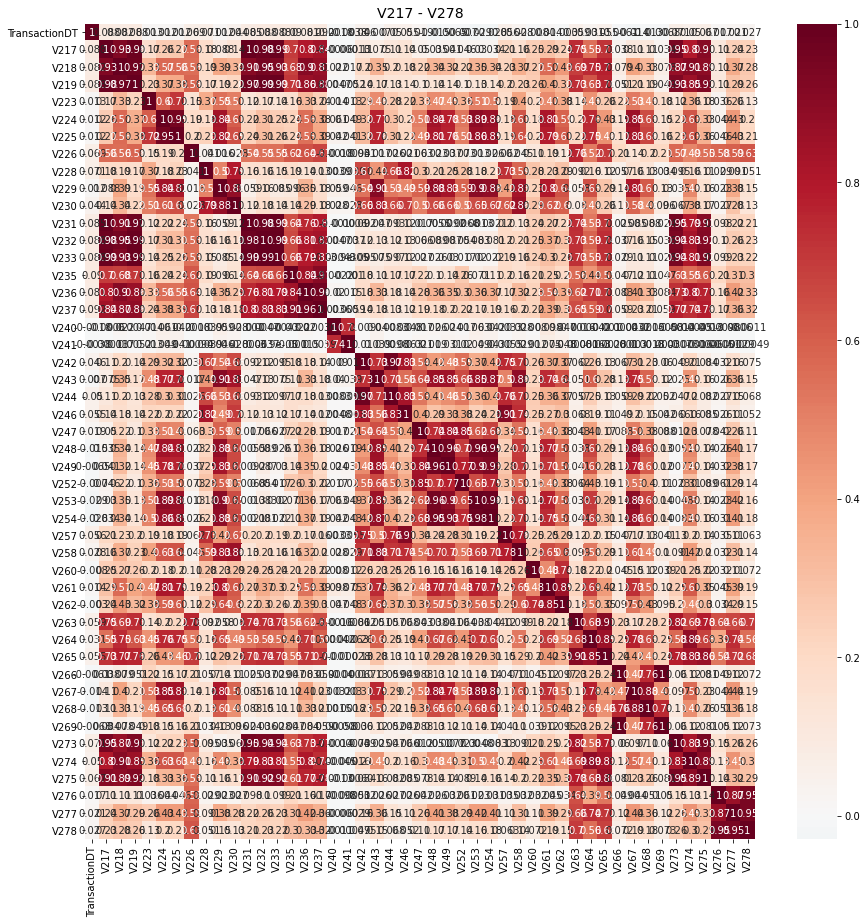

In [58]:
Vs = [x for x in nans_groups[460110]]
make_corr(Vs)

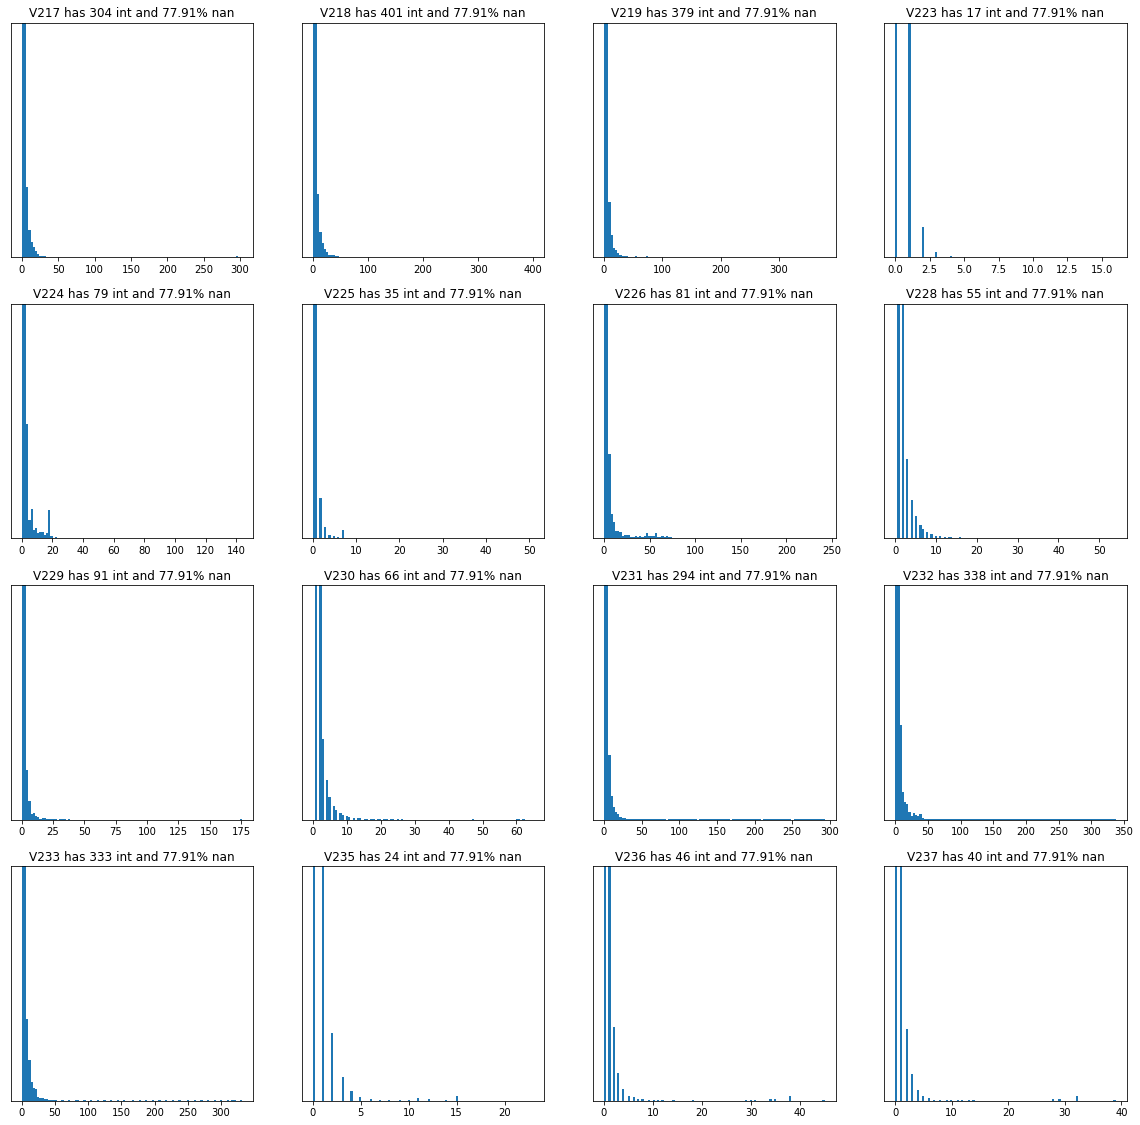

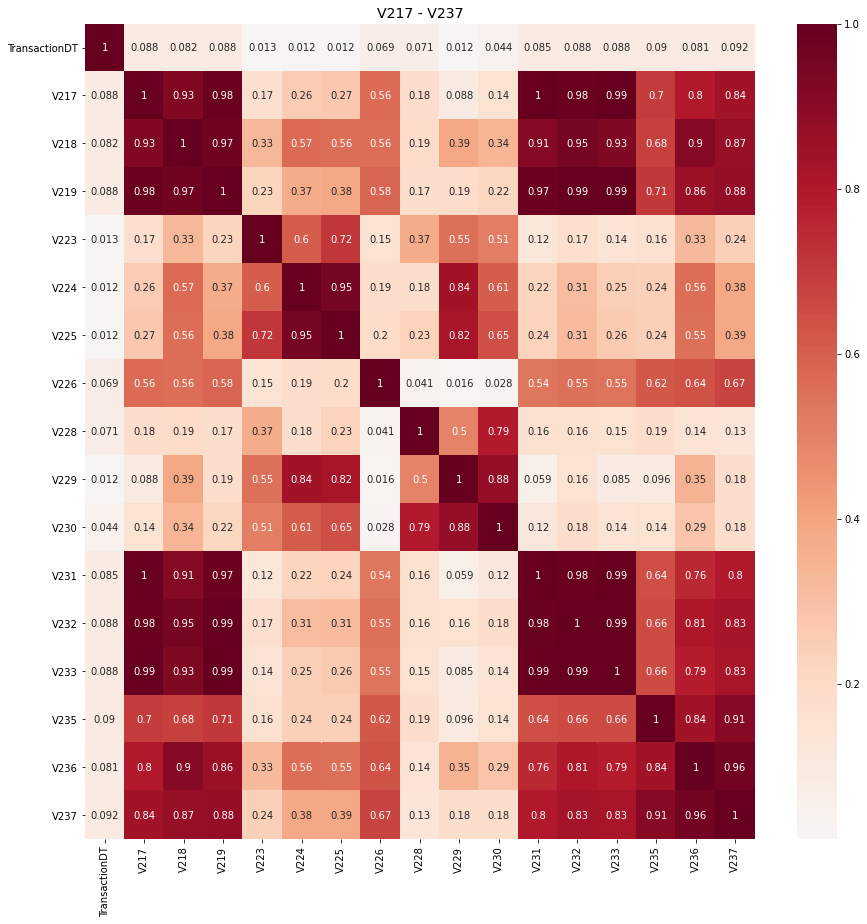

In [59]:
Vs = [x for x in nans_groups[460110] if int(x[1:])<240]
make_plots(Vs)
make_corr(Vs)

In [60]:
grps = [[217,218,219,231,232,233,236,237],[223],[224,225],[226],[228],[229,230],[235]]
reduce_group(grps)

Use these [218, 223, 224, 226, 228, 229, 235]


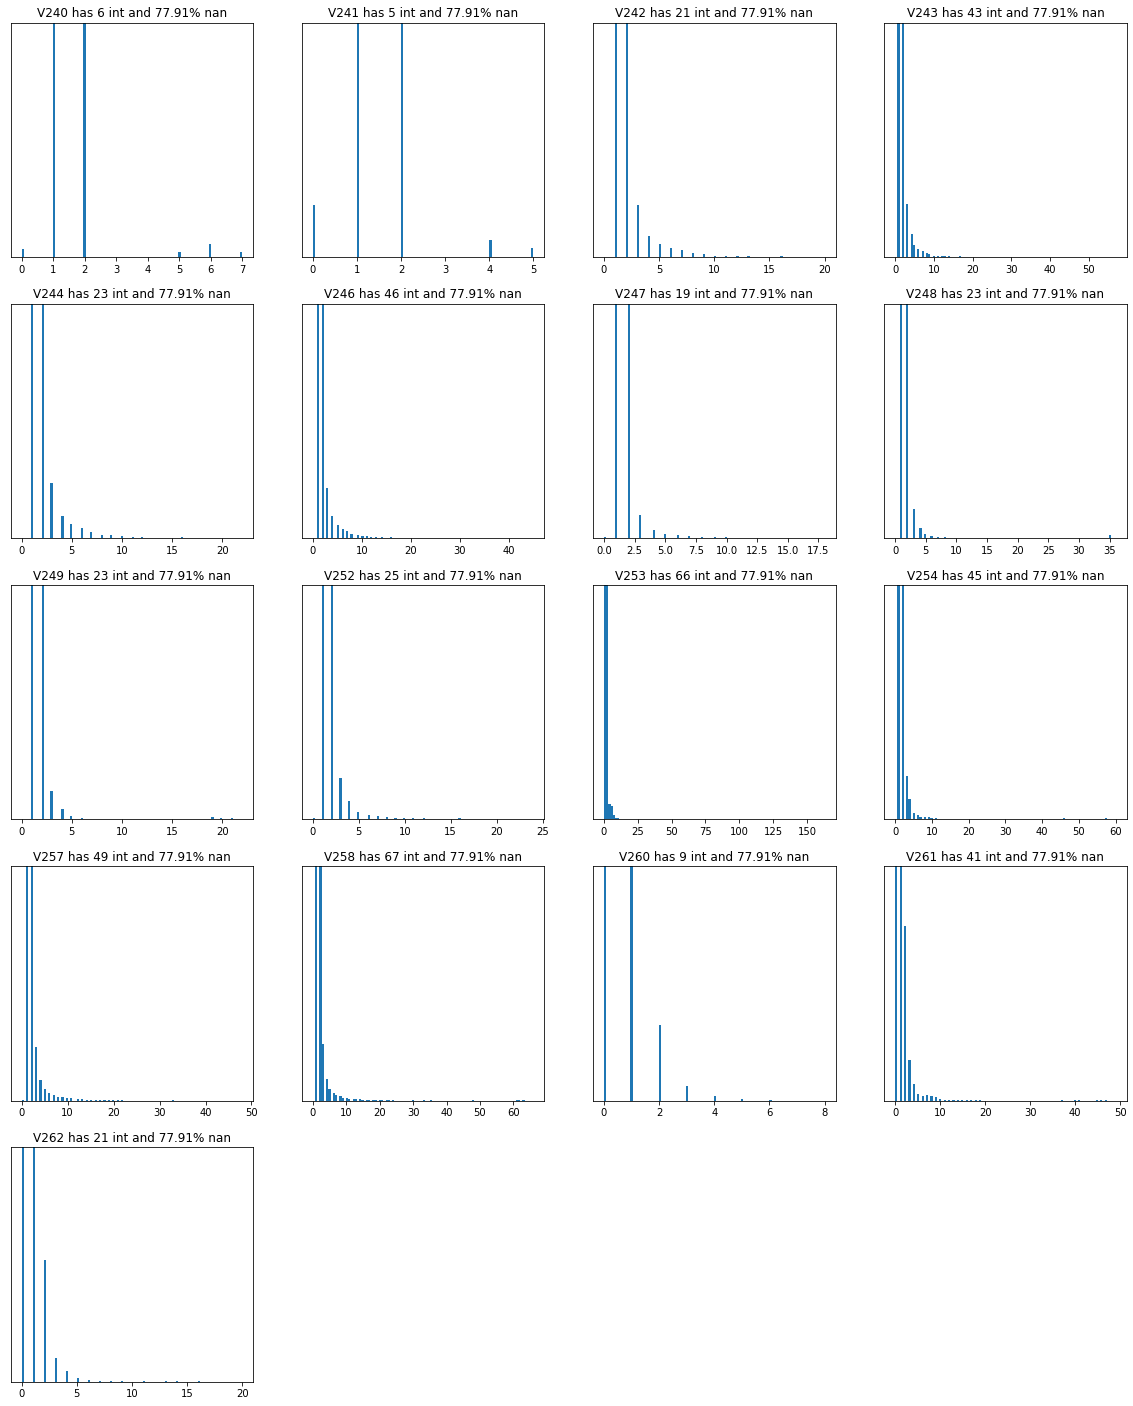

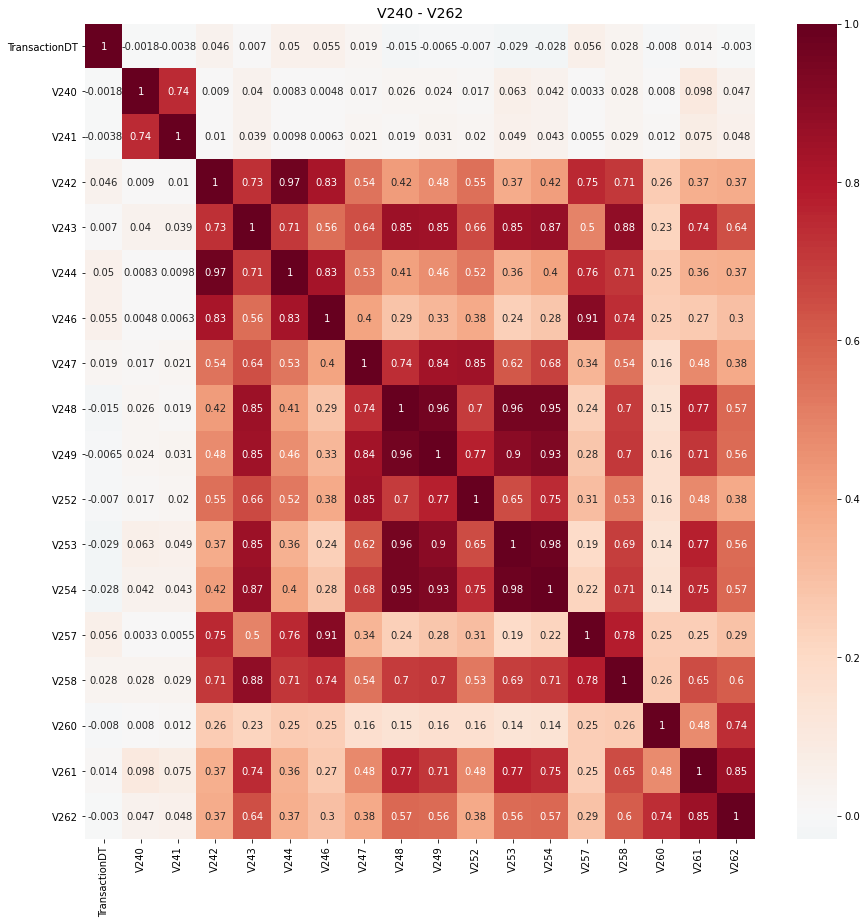

In [61]:
Vs = [x for x in nans_groups[460110] if (int(x[1:])>237)&(int(x[1:])<263)]
make_plots(Vs)
make_corr(Vs)

In [62]:
grps = [[240,241],[242,243,244,258],[246,257],[247,248,249,253,254],[252],[260],[261,262]]
reduce_group(grps)

Use these [240, 258, 257, 253, 252, 260, 261]


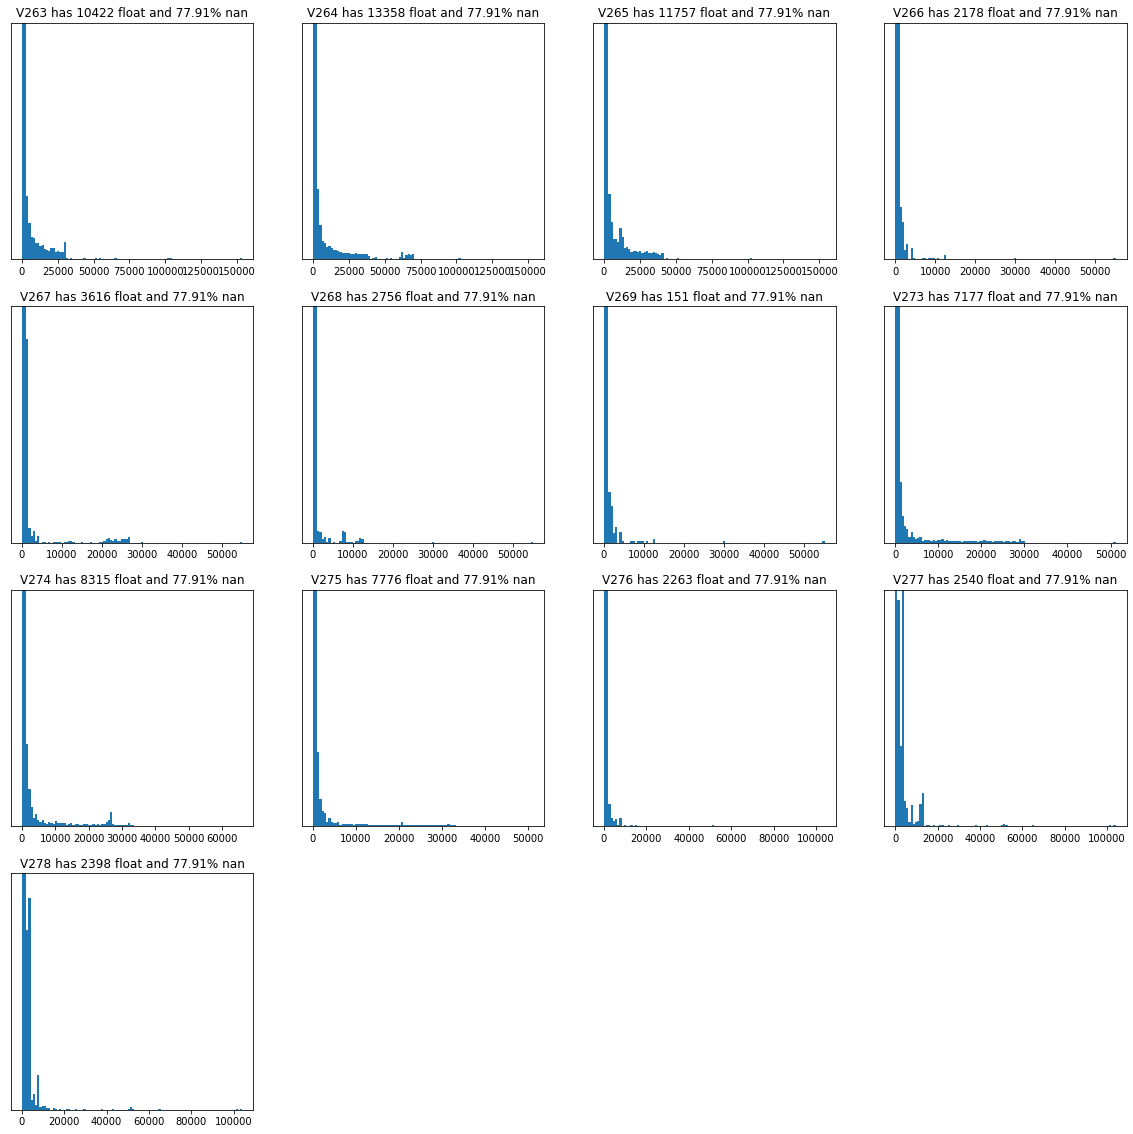

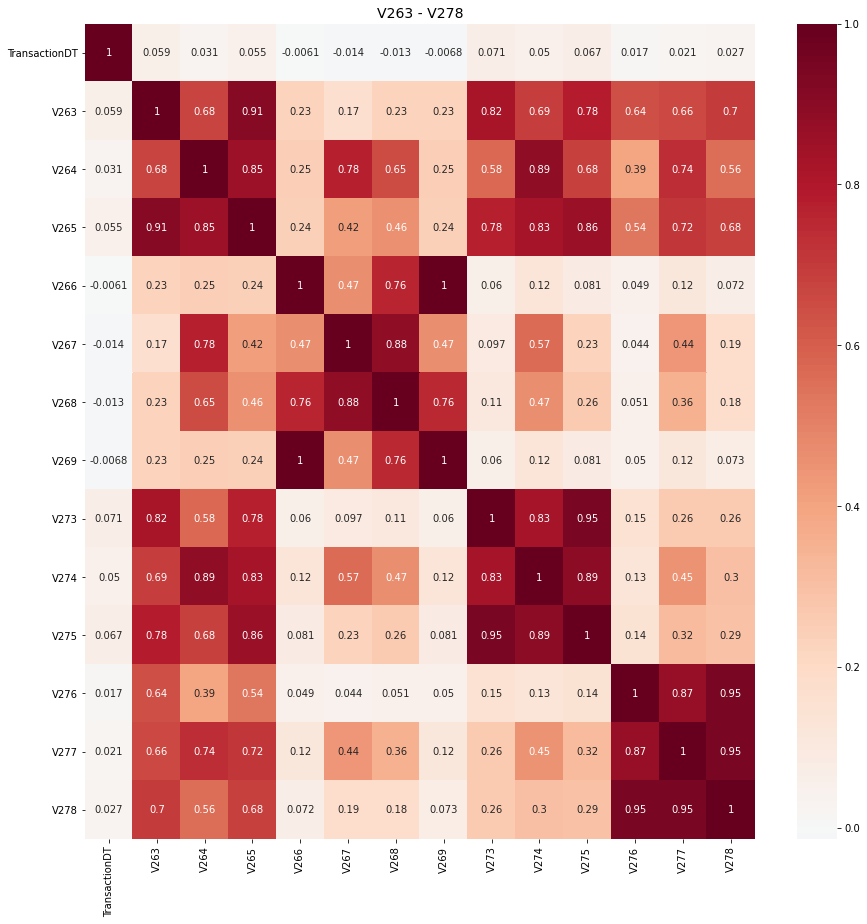

In [63]:
Vs = [x for x in nans_groups[460110] if (int(x[1:])>262)]
make_plots(Vs)
make_corr(Vs)

In [64]:
grps = [[263,265,264],[266,269],[267,268],[273,274,275],[276,277,278]]
reduce_group(grps)

Use these [264, 266, 267, 274, 277]


**V220 ~ V272**

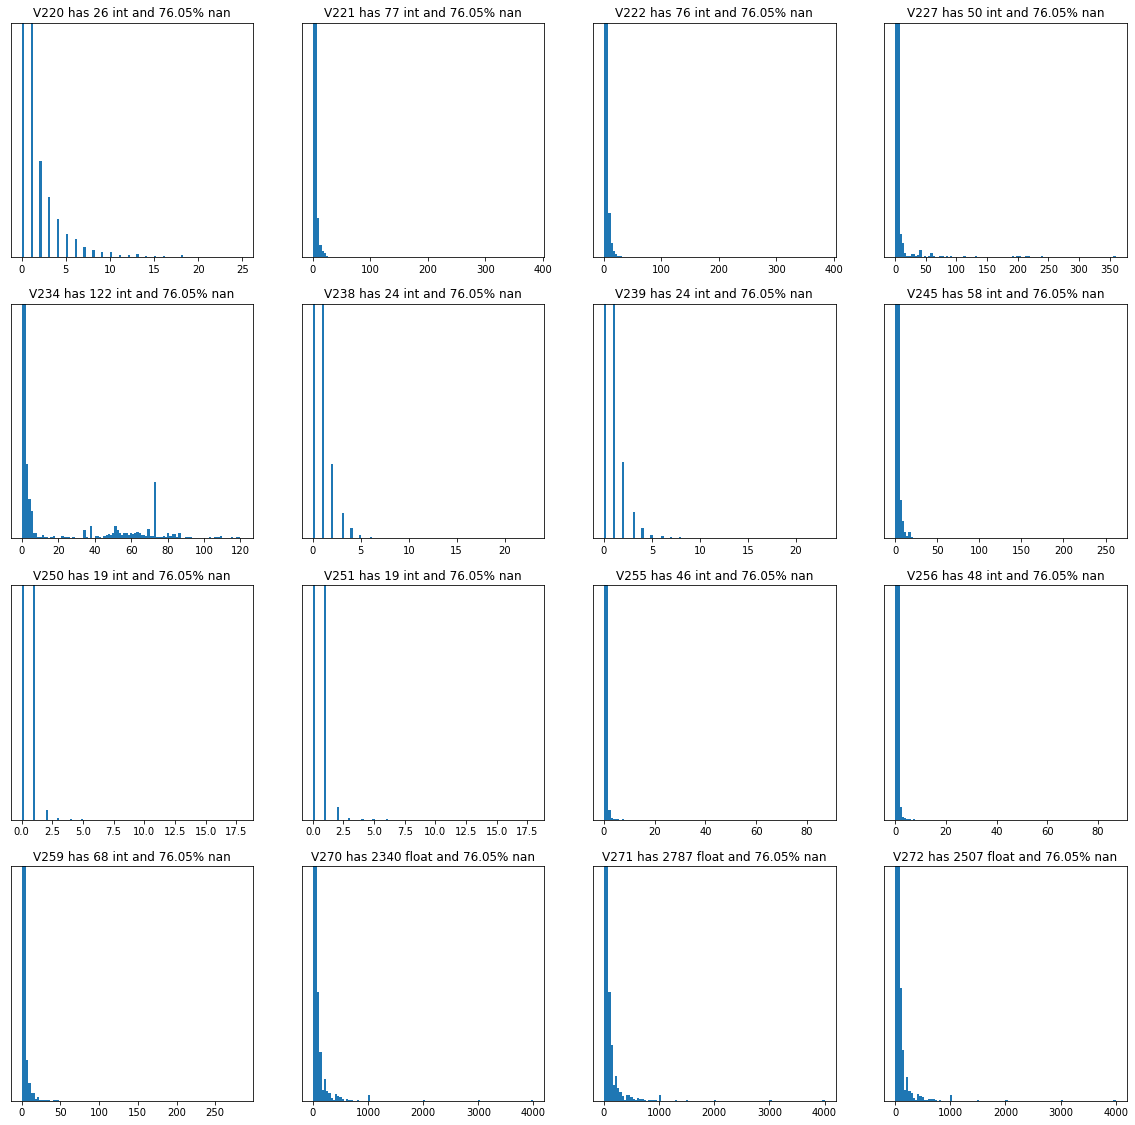

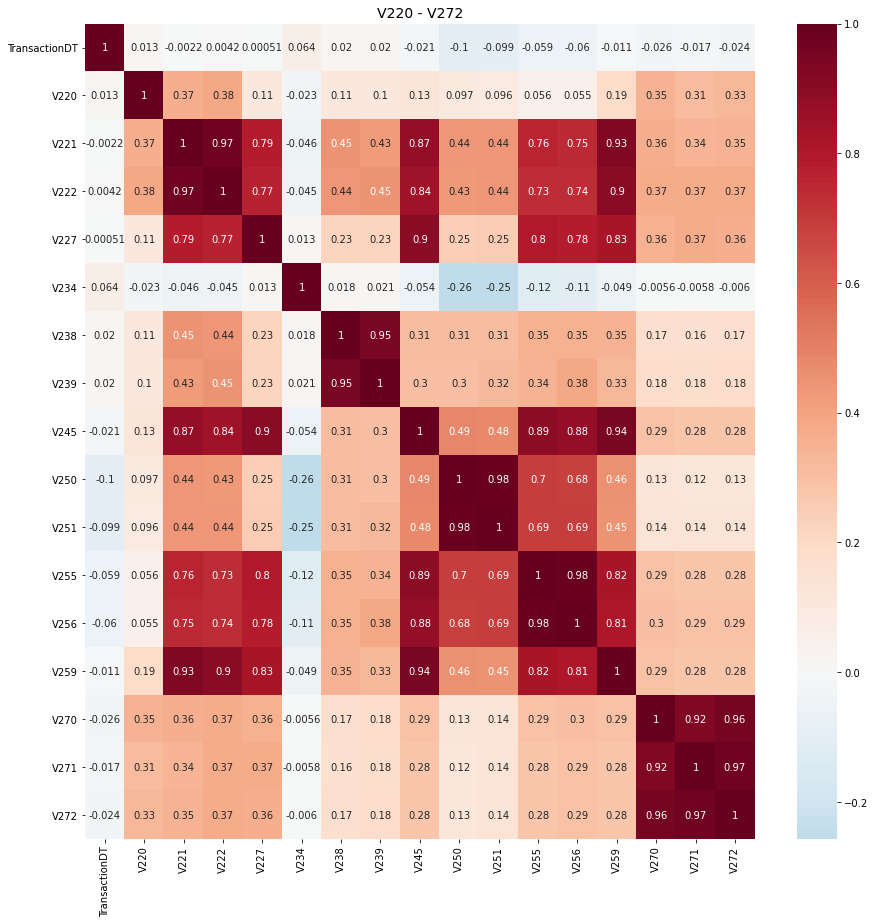

In [65]:
Vs = nans_groups[449124]
make_plots(Vs)
make_corr(Vs)

In [66]:
grps = [[220],[221,222,227,245,255,256,259],[234],[238,239],[250,251],[270,271,272]]
reduce_group(grps)

Use these [220, 221, 234, 238, 250, 271]


**V279 ~ V321**

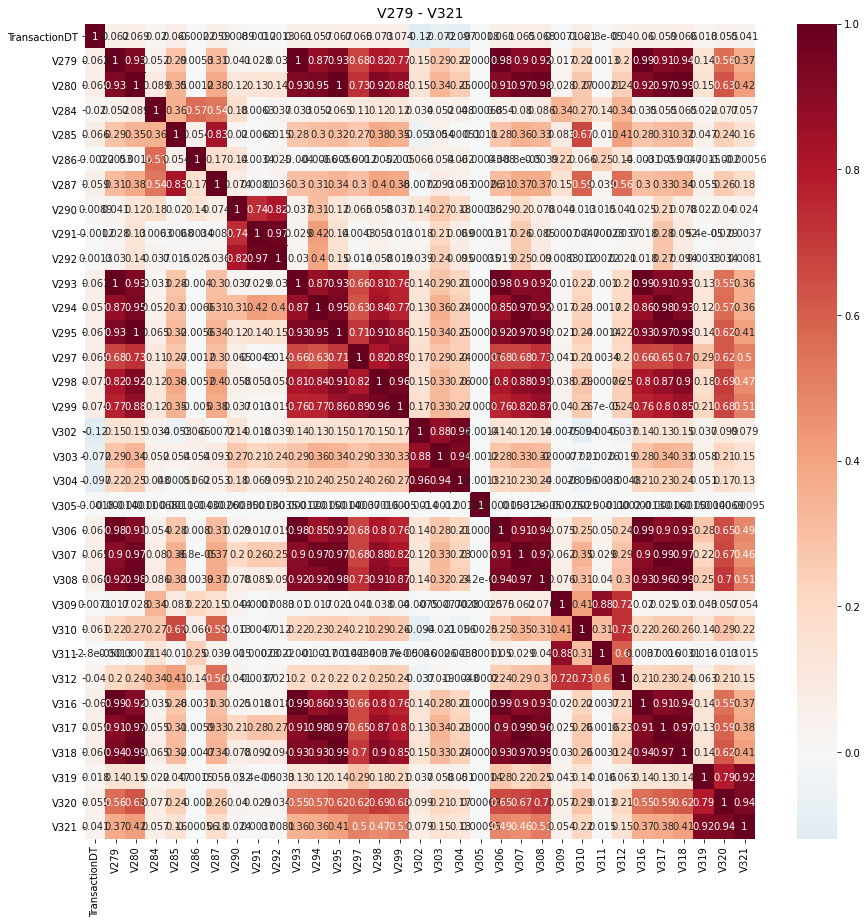

In [67]:
Vs = [x for x in nans_groups[12]]
make_corr(Vs)

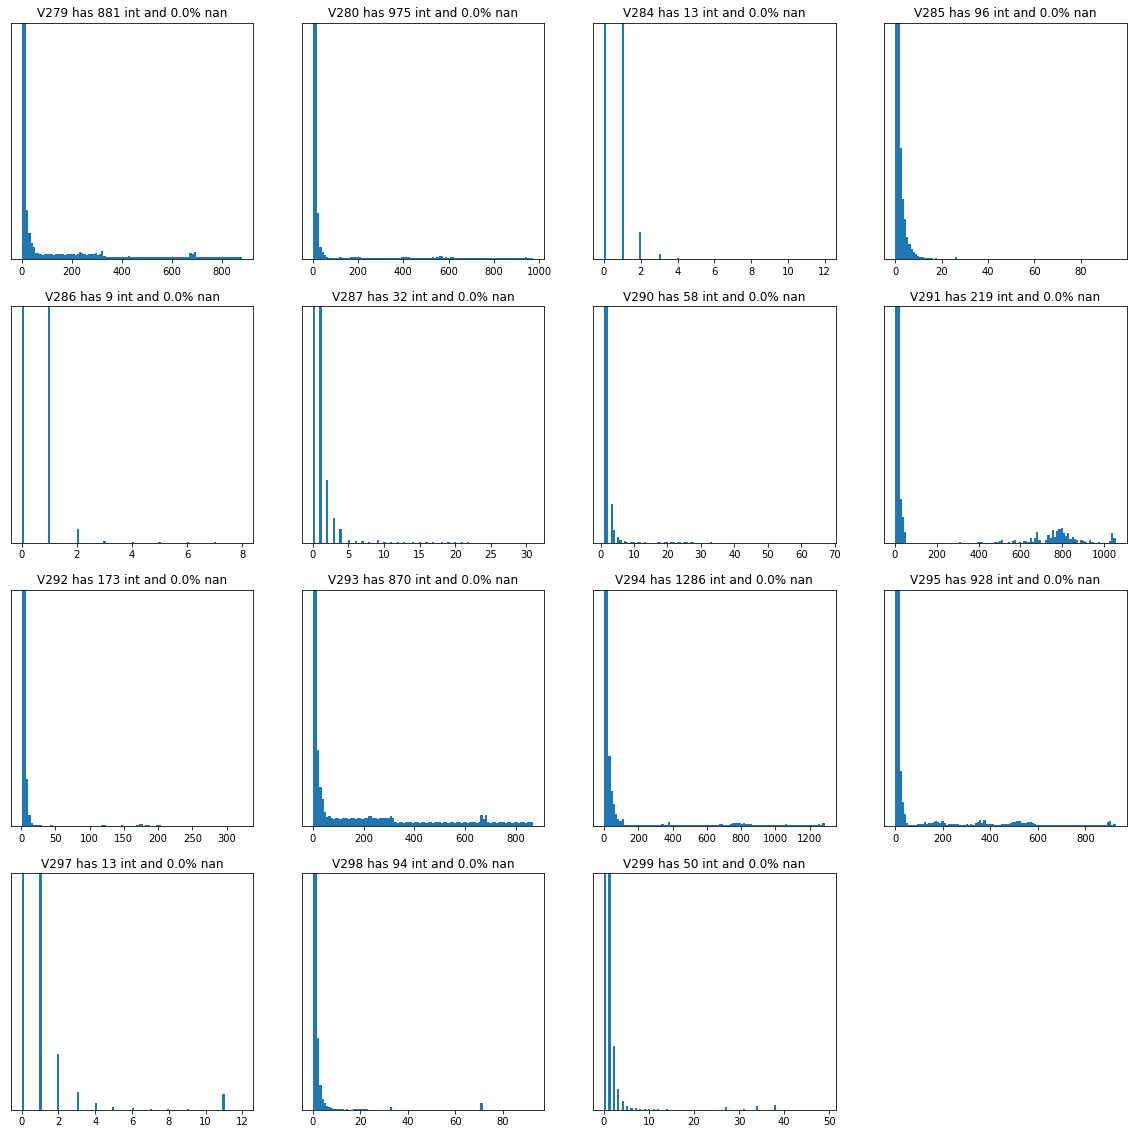

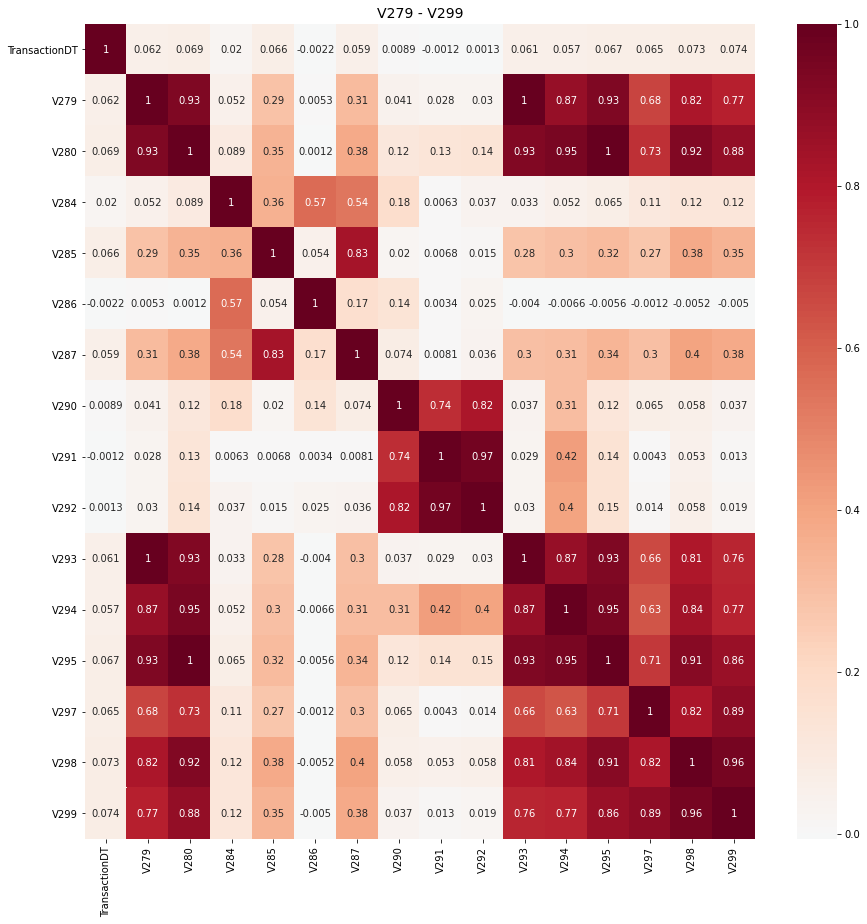

In [68]:
Vs = [x for x in nans_groups[12] if int(x[1:])<302]
make_plots(Vs)
make_corr(Vs)

In [69]:
grps = [[279,280,293,294,295,298,299],[284],[285,287],[286],[290,291,292],[297]]
reduce_group(grps)

Use these [294, 284, 285, 286, 291, 297]


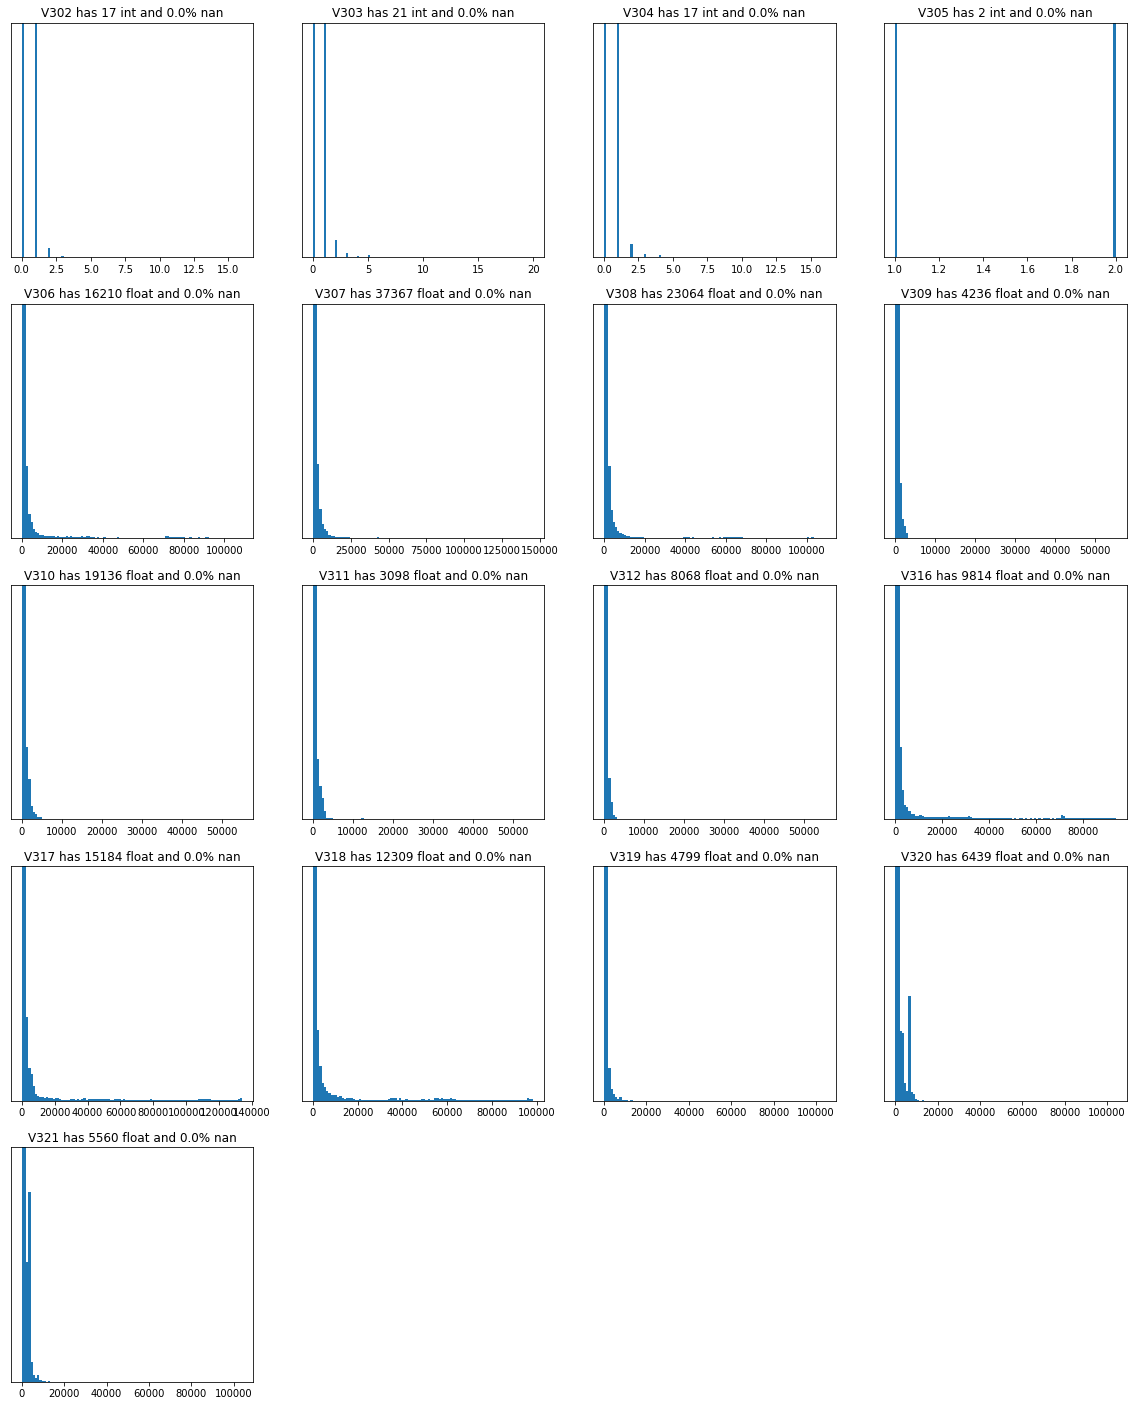

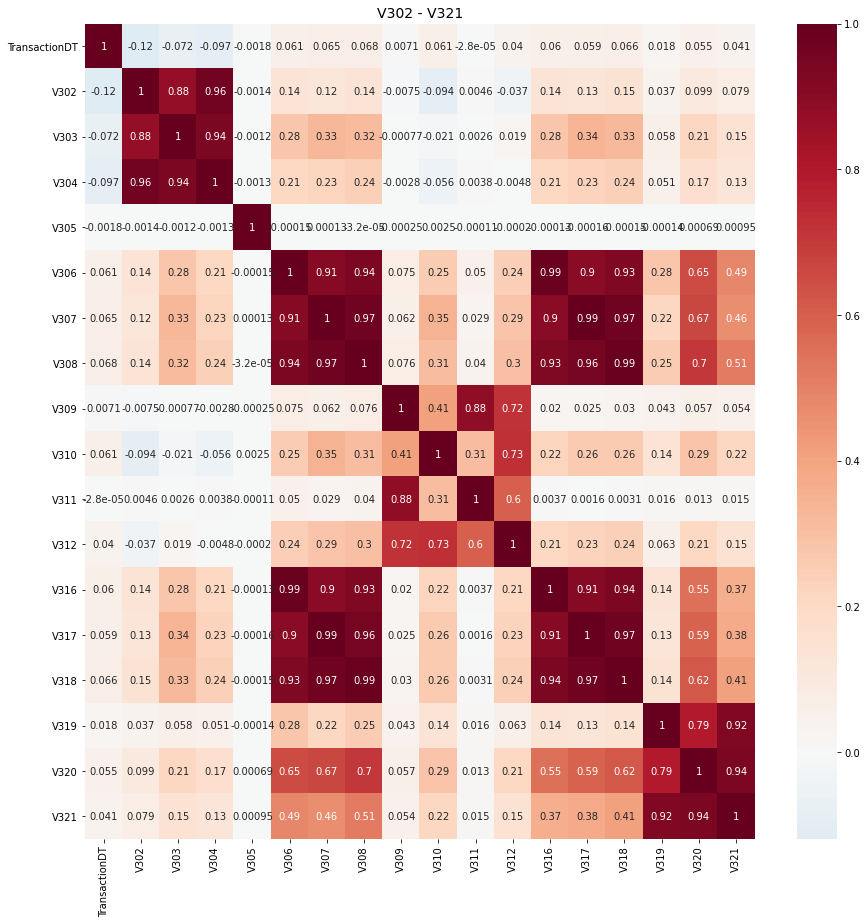

In [70]:
Vs = [x for x in nans_groups[12] if int(x[1:])>299]
make_plots(Vs)
make_corr(Vs)

In [71]:
grps = [[302,303,304],[305],[306,307,308,316,317,318],[309,311],[310,312],[319,320,321]]
reduce_group(grps)

Use these [303, 305, 307, 309, 310, 320]


**V281 ~ V315, D1**

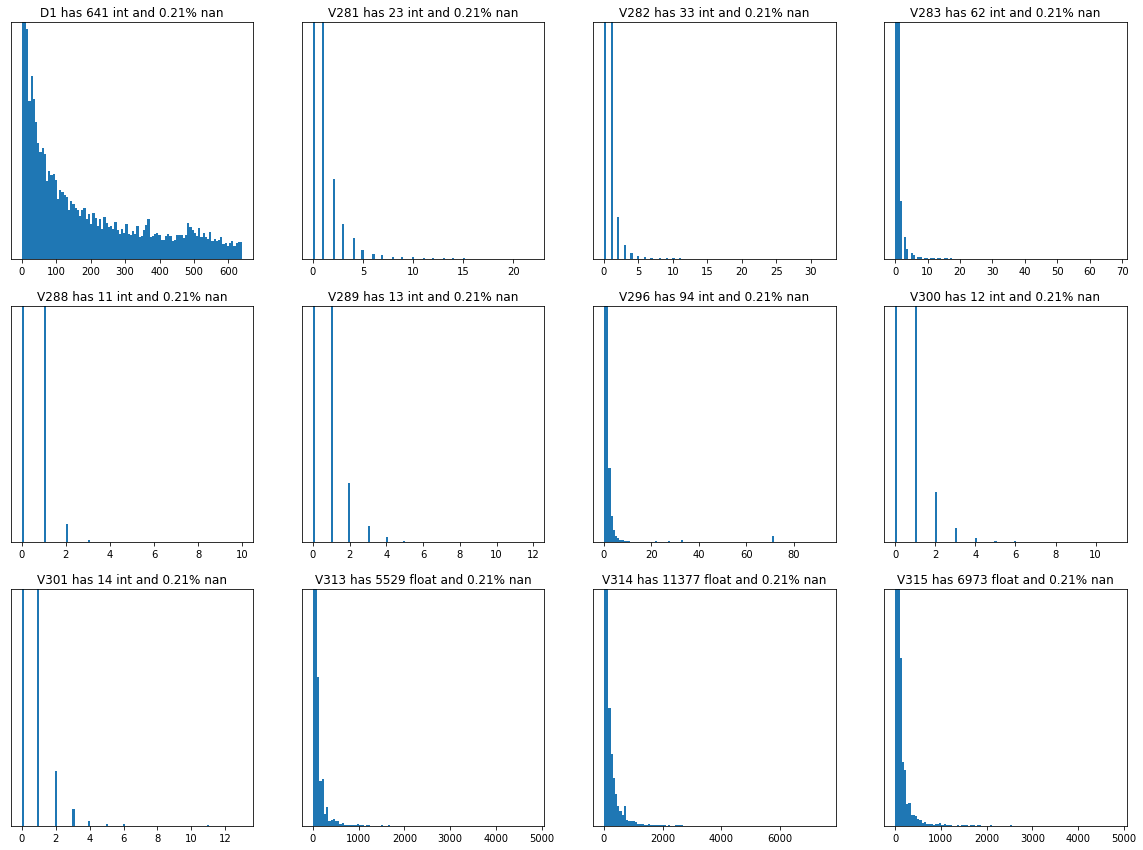

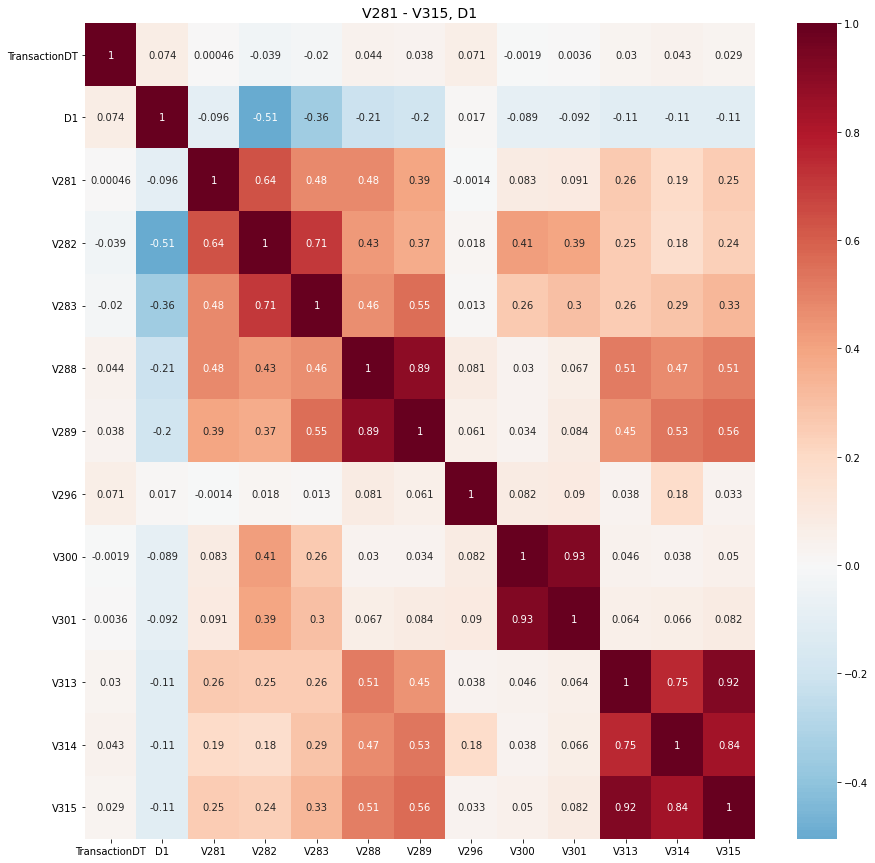

In [72]:
Vs = nans_groups[1269]
make_plots(Vs)
Vtitle = 'V281 - V315, D1'
make_corr(Vs,Vtitle)

In [73]:
grps = [[281],[282,283],[288,289],[296],[300,301],[313,314,315]]
reduce_group(grps)

Use these [281, 283, 289, 296, 301, 314]


**V322 - V339**

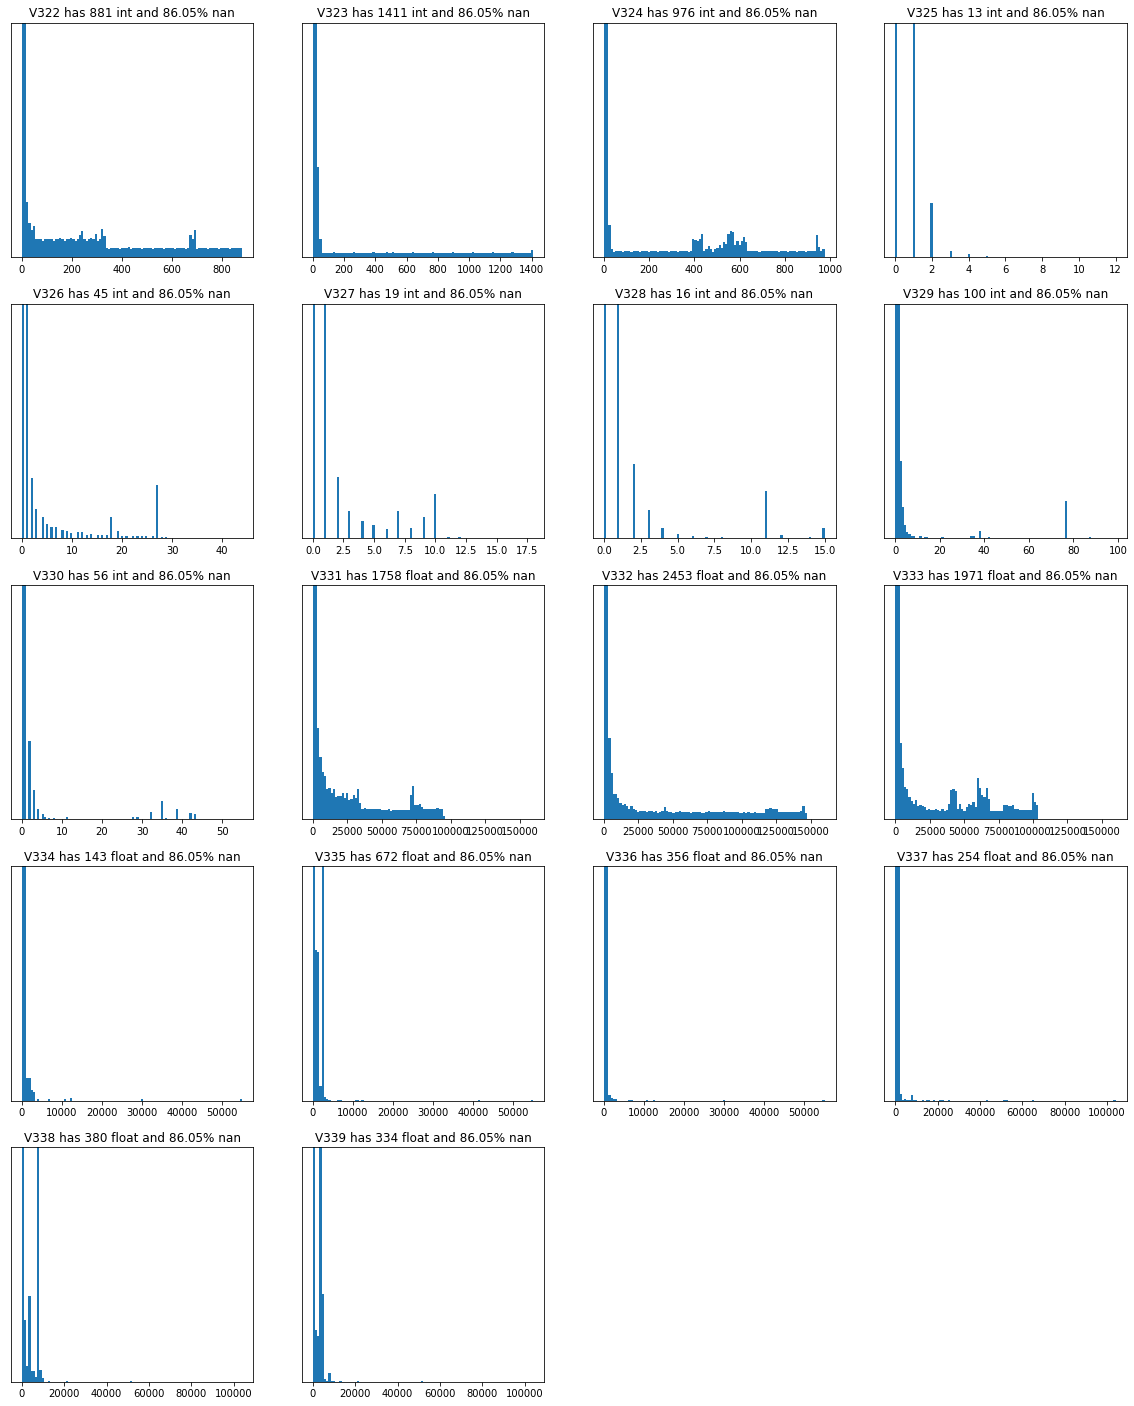

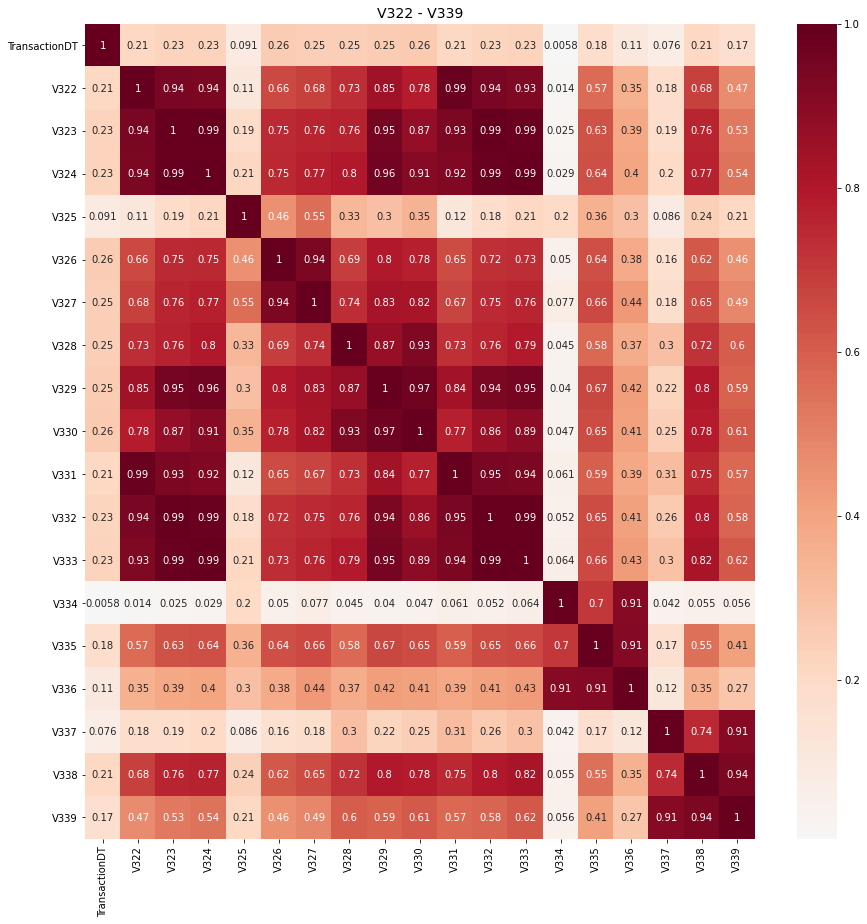

In [74]:
Vs = nans_groups[508189]
make_plots(Vs)
make_corr(Vs)

In [75]:
grps = [[322,323,324,326,327,328,329,330,331,332,333],[325],[334,335,336],[337,338,339]]
reduce_group(grps)

Use these [332, 325, 335, 338]


# V Reduced
Wow, even this reduced set still has much internal correlation. These V columns are highly redundant!

In [76]:
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]

In [77]:
print('Reduced set has',len(v),'columns')

Reduced set has 128 columns


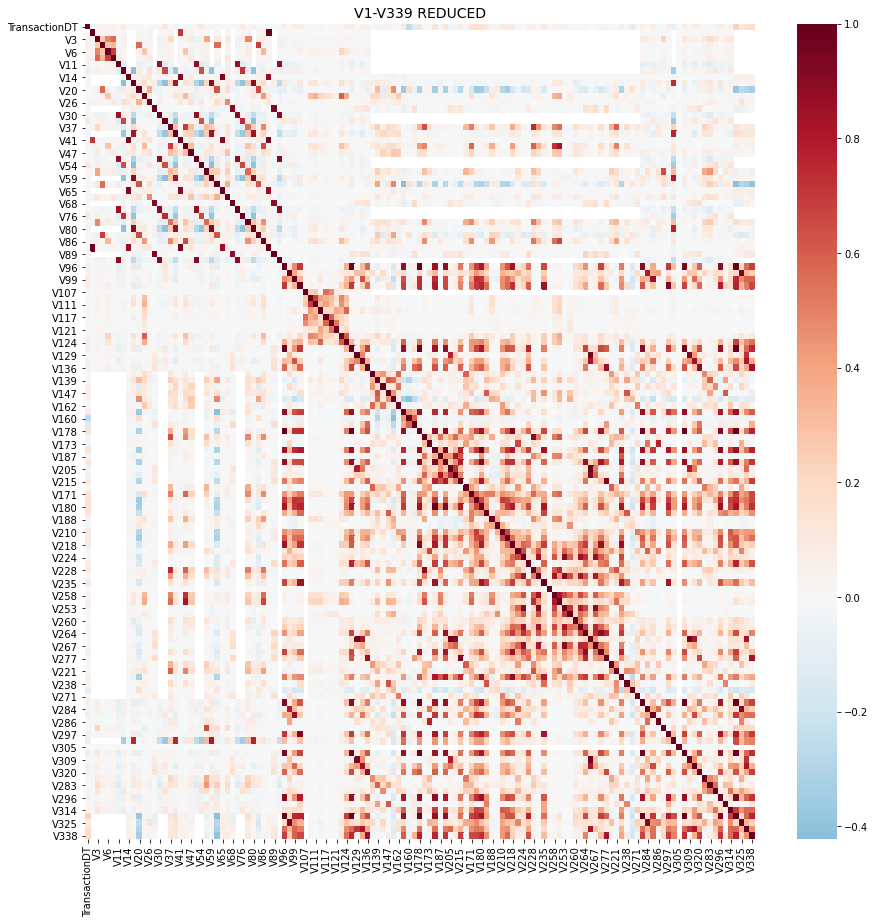

In [78]:
cols = ['TransactionDT'] + ['V'+str(x) for x in v]
train2 = train[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 REDUCED',fontsize=14)
plt.show()

# V All
We notice that the first 100 Vs don't correlate much with the last 239 Vs. Also even though the first 100 have 6 different NAN groups there is much correlation between the groups. The latter 239 relate to each other.



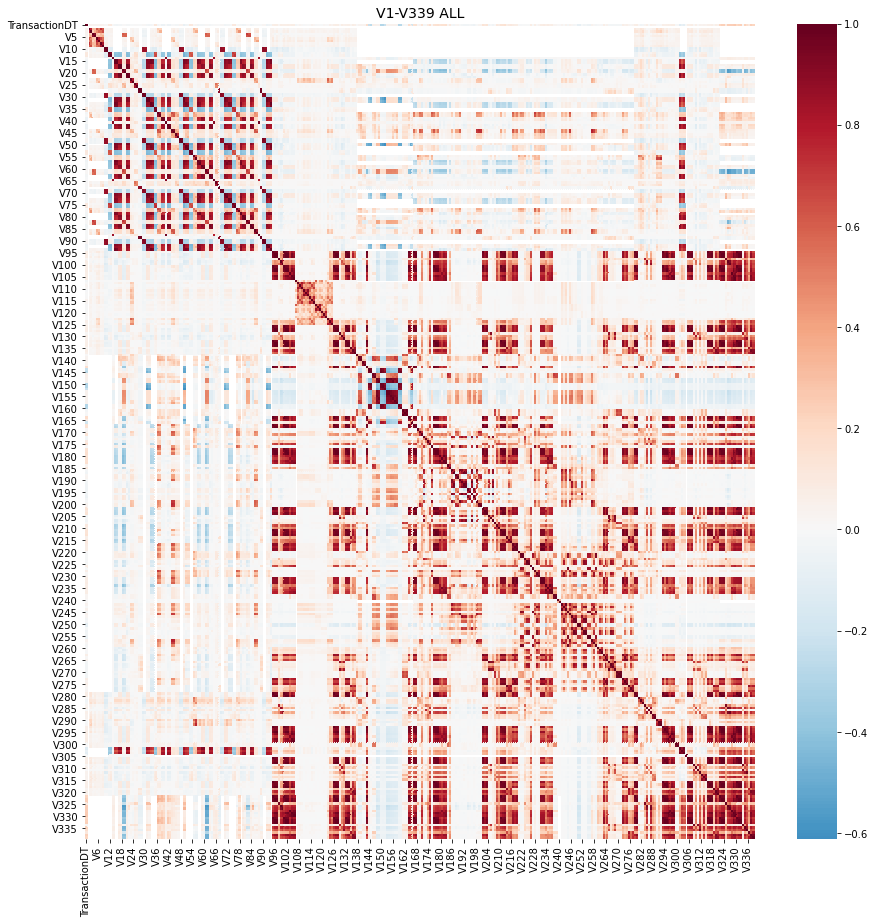

In [79]:
cols = ['TransactionDT'] + ['V'+str(x) for x in range(1,340)]
train2 = train[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 ALL',fontsize=14)
plt.show()

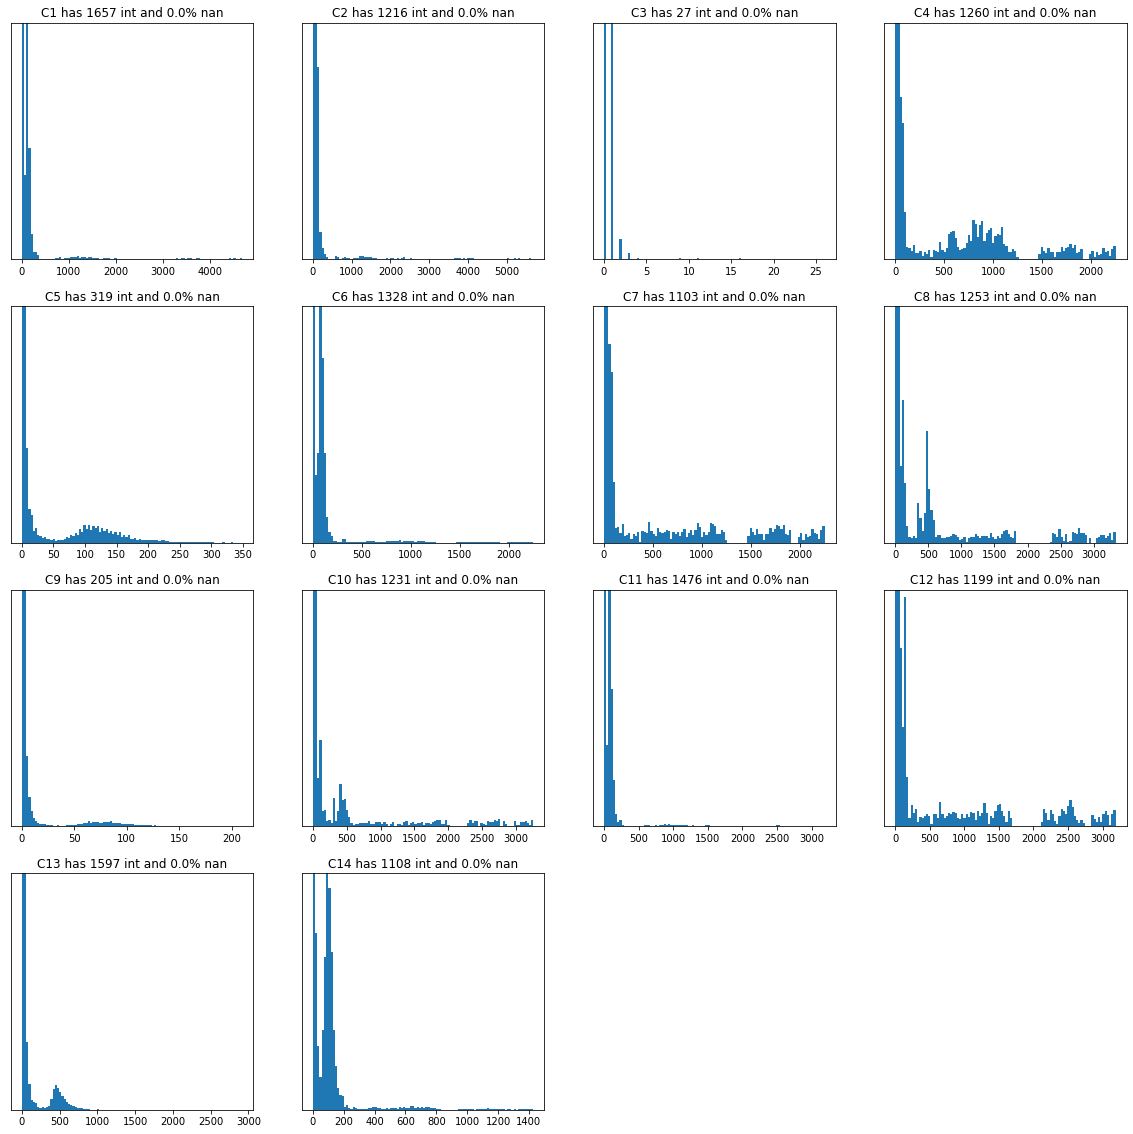

In [80]:
def make_plots2(Vs):
    col = 4
    row = len(Vs)//4+1
    plt.figure(figsize=(20,row*5))
    for i,v in enumerate(Vs):
        plt.subplot(row,col,i+1)
        idx = train[~train[v].isna()].index
        n = train[v].nunique()
        x = np.sum(train.loc[idx,v]!=train.loc[idx,v].astype(int))
        y = np.round(100*np.sum(train[v].isna())/len(train),2)
        t = 'int'
        if x!=0: t = 'float'
        plt.title(v+' has '+str(n)+' '+t+' and '+str(y)+'% nan')
        plt.yticks([])
        h = plt.hist(train.loc[idx,v],bins=100)
        if len(h[0])>1: plt.ylim((0,np.sort(h[0])[-2]))
    plt.show()
make_plots2(['C'+str(x) for x in range(1,15)])

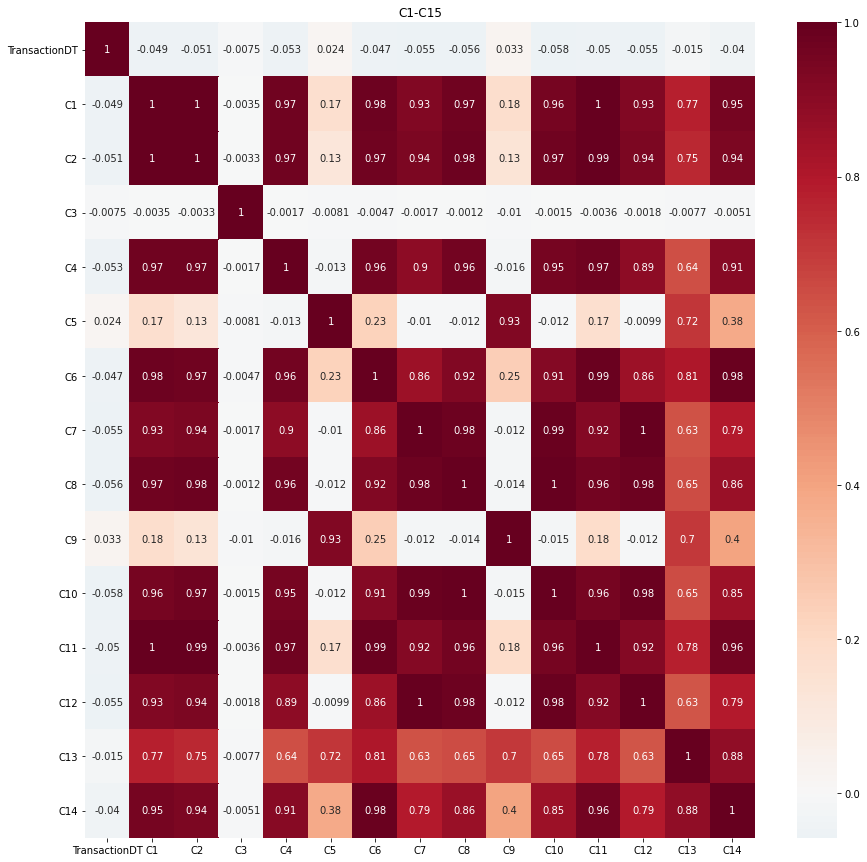

In [81]:
cols = ['TransactionDT'] + ['C'+str(x) for x in range(1,15)]
plt.figure(figsize=(15,15))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('C1-C15')
plt.show()

**D-Columns**

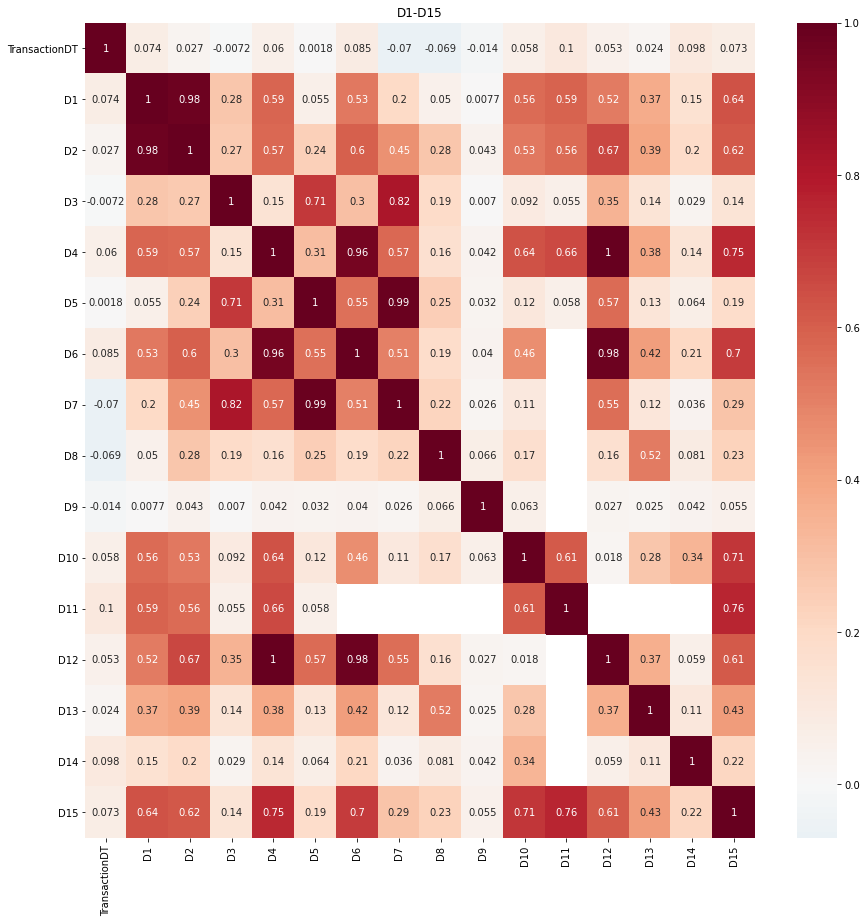

In [82]:
cols = ['TransactionDT'] + ['D'+str(x) for x in range(1,16)]
plt.figure(figsize=(15,15))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('D1-D15')
plt.show()

**M-Columns**

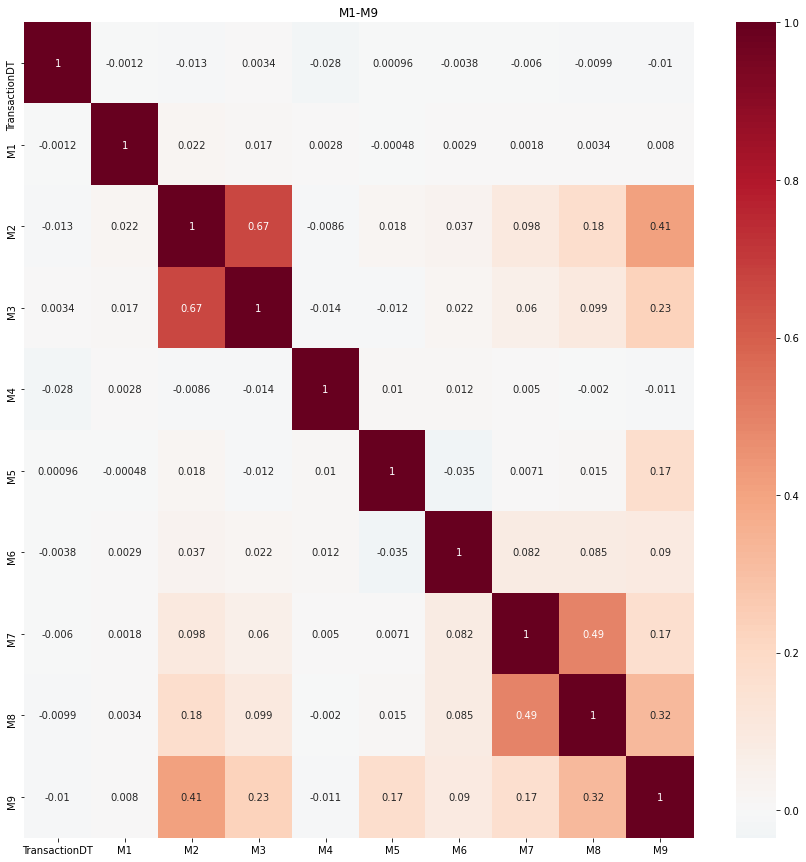

In [83]:
Ms = ['M'+str(x) for x in range(1,10)]
mp = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
for c in Ms: train[c] = train[c].map(mp)

cols = ['TransactionDT'] + Ms
plt.figure(figsize=(15,15))
sns.heatmap(train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('M1-M9')
plt.show()

**ID-Columns**

In [84]:
train_id = pd.read_csv('train_identity.csv')
train_id = pd.merge(train_id,train[['TransactionID','TransactionDT']],on='TransactionID',how='left')
ids = ['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,39)]
for c in ids: print (c,train_id[c].unique()[:10])

id_01 [  0.  -5. -15. -10. -20. -40. -30. -25. -55. -45.]
id_02 [ 70787.  98945. 191631. 221832.   7460.  61141.     nan  31964. 116098.
 257037.]
id_03 [nan  0.  3.  2.  5.  1.  6.  9.  4. -5.]
id_04 [ nan   0. -11.  -5.  -8.  -1.  -6.  -9.  -3. -13.]
id_05 [nan  0.  1.  3.  2.  9. 12.  6.  4. 21.]
id_06 [ nan  -5.   0.  -6. -10. -11.  -1.  -4. -43.  -9.]
id_07 [nan 22.  6. -1.  4.  2. 17. 12. 27.  5.]
id_08 [  nan  -34.  -55. -100.  -15.  -33.  -13.  -36.  -44.  -26.]
id_09 [nan  0.  3.  2.  1.  5. -8.  7.  4.  6.]
id_10 [ nan   0.  -9. -42.  -6. -29.  -8.  -1.  -5. -11.]
id_11 [100.                  nan  93.75        95.08000183  95.65000153
  94.29000092  96.19000244  90.56999969  97.54000092  96.43000031]
id_12 ['NotFound' 'Found']
id_13 [nan 49. 52. 14. 20. 55. 43. 18. 41. 63.]
id_14 [-480. -300.   nan -360. -420. -540. -600.  480. -240.  300.]
id_15 ['New' 'Found' nan 'Unknown']
id_16 ['NotFound' 'Found' nan]
id_17 [166. 121. 225.  nan 102. 148. 199. 146. 144. 133.]
id_18 [nan 1

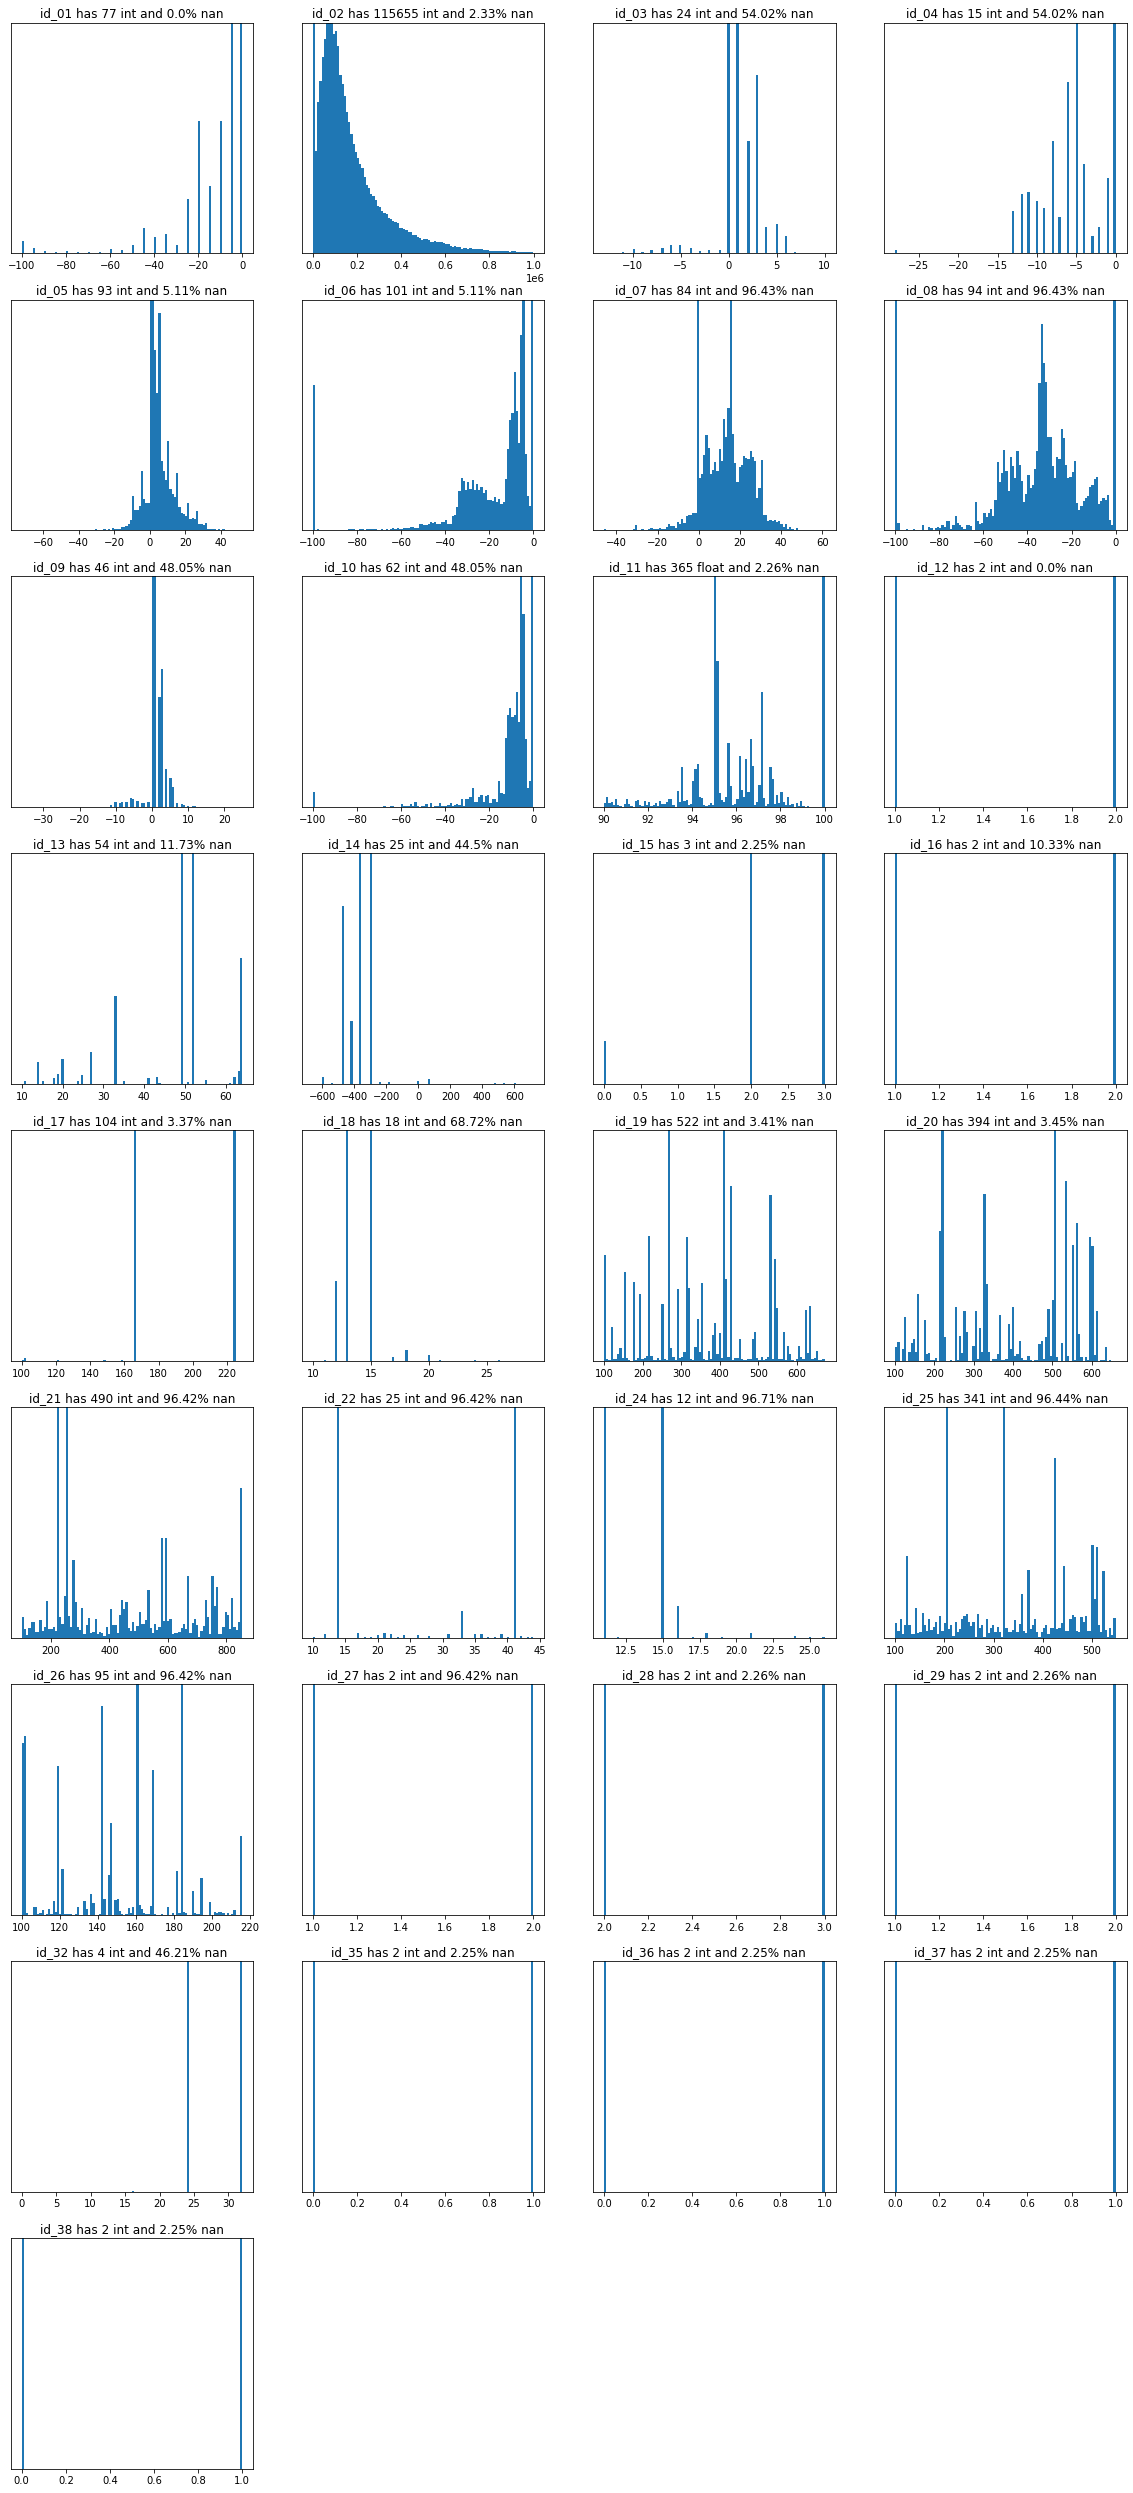

In [85]:
booln = ['id_12','id_15','id_16','id_27','id_28','id_29','id_35','id_36','id_37','id_38']
cats = ['id_23','id_30','id_31','id_33','id_34']
mp = {'Unknown':0,'NotFound':1,'Found':2,'New':3,'F':0,'T':1}
for c in booln: train_id[c] = train_id[c].map(mp)

def make_plots2(Vs):
    col = 4
    row = len(Vs)//4+1
    plt.figure(figsize=(20,row*5))
    for i,v in enumerate(Vs):
        plt.subplot(row,col,i+1)
        idx = train_id[~train_id[v].isna()].index
        n = train_id[v].nunique()
        x = np.sum(train_id.loc[idx,v]!=train_id.loc[idx,v].astype(int))
        y = np.round(100*np.sum(train_id[v].isna())/len(train_id),2)
        t = 'int'
        if x!=0: t = 'float'
        plt.title(v+' has '+str(n)+' '+t+' and '+str(y)+'% nan')
        plt.yticks([])
        h = plt.hist(train_id.loc[idx,v],bins=100)
        if len(h[0])>1: plt.ylim((0,np.sort(h[0])[-2]))
    plt.show()
make_plots2([x for x in ids if x not in cats])

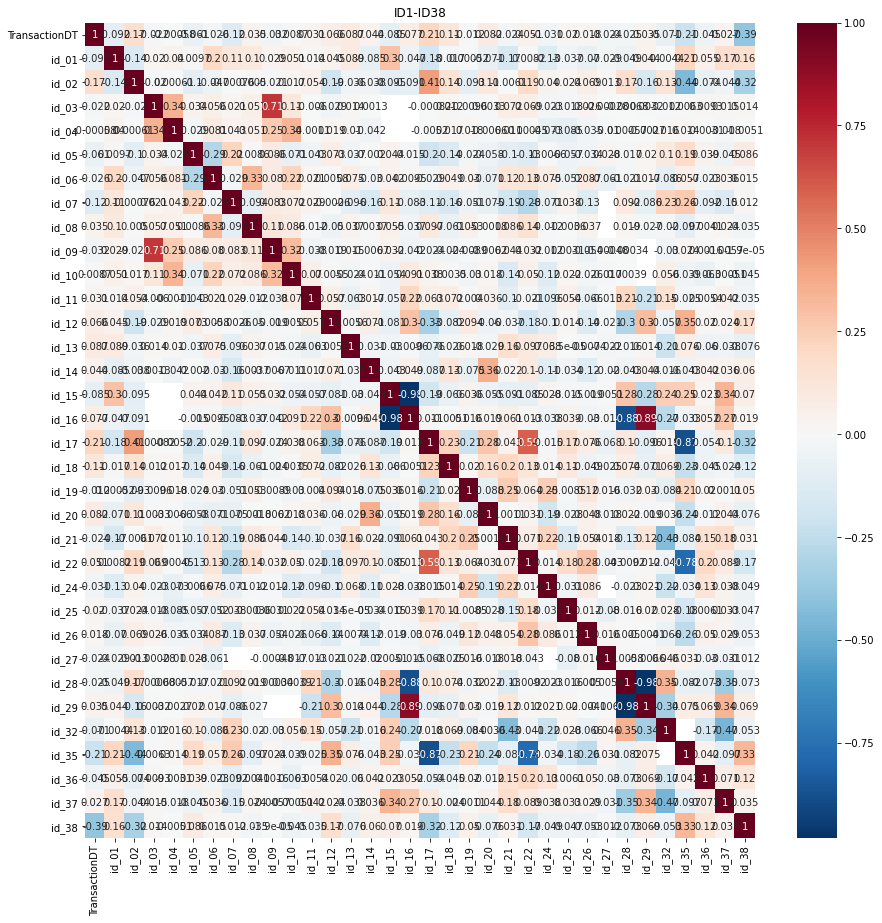

In [86]:
cols = ['TransactionDT'] + [x for x in ids if x not in cats]
plt.figure(figsize=(15,15))
sns.heatmap(train_id[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('ID1-ID38')
plt.show()

# RAPIDS - Feature Engineering - 1st Place Fraud Comp - [0.96]
The secret to creating a high scoring model in Kaggle's IEEE CIS Fraud Competition is feature engineering. A list of feature engineering techniques is posted here. The most important features in Fraud Comp are new columns created from group aggregations of other columns. Why this works is explained here. Computing group aggregations can naturally be done in parallel and benefit from using GPU instead of CPU.

This notebook contains the XGBoost model of the 1st place Fraud Comp solution converted to use RAPIDS cuDF. (The entire 1st place solution is an ensemble of XGBoost, CatBoost, and LightGBM with additional post processing described here). To read one million rows from disk and create 262 features on CPU using Pandas takes 5 minutes. To read and create those features on GPU with RAPIDS cuDF takes 20 seconds as shown below. RAPIDS is 15x faster!

In [88]:
%%time
# INSTALL RAPIDS OFFLINE (FROM KAGGLE DATASET). TAKES 1 MINUTE :-)
import sys
!pip install rapid-framework

     |████████████████████████████████| 92kB 3.6MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 81kB 4.6MB/s 
  Created wheel for rapid-framework: filename=rapid_framework-20.1216.141314-cp37-none-any.whl size=177794 sha256=53cb91d48399cd8ea56a051febb9cbe540e40e46c7c69ca54e1a096d350c5eef
  Stored in directory: /root/.cache/pip/wheels/ac/4a/f6/1eb18e8d832ae281ce9f7d5aa8755834be000e54df8a8c34c8
  Created wheel for simplejson: filename=simplejson-3.10.0-cp37-cp37m-linux_x86_64.whl size=113773 sha256=3f6c1b89f83f76bfe70f9847625d936cc324157140167b0747dced56a5d4dfc3
  Stored in directory: /root/.cache/pip/wheels/e3/20/ee/81fe92f973c9be72ddd49a252a327bdce88c7be3c36467c0a0
  Created wheel for simpleeval: filename=simpleeval-0.9.10-cp37-none-any.whl size=13759 sha256=cbdba33678122d6d6827c4b456abbfc678bade2551a81323e319bf60e9d7e129
  Stored in directory: /root/.cache/pip/wheels/20/ab/91/eeb7746161f88e6ea897483494ab6034ebce9884b8f2dea7e5
Success

CPU times: user 149 ms, sys: 56.5 ms, total: 206 ms
Wall time: 13.9 s


In [89]:
!pip install rapids

     |████████████████████████████████| 256kB 4.3MB/s 
     |████████████████████████████████| 256kB 7.0MB/s 
     |████████████████████████████████| 122kB 8.9MB/s 


In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh


In [96]:
!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18
import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())


PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

2. IMPORTANT NOTICE: CuGraph's Louvain requires a Volta+ GPU (T4, V100).  If you get a P4 or P100 and intend to use Louvain, please FACTORY RESET your instance and try to get a compatible GPU
3. Default stable version is now 0.18.  Nightly is now 0.19.
3. You can declare your RAPIDSAI version as a CLI option and skip the user prompts 

In [97]:
import cudf, cupy, math, warnings, time 
from numba import cuda, float32, int8
import numpy as np, pandas as pd, os, gc
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

LOCAL_VALIDATION = False

# LIST COLUMNS TO LOAD
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']
# USEFUL V COLUMNS
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [107, 108, 111, 115, 117, 120, 121, 123] 
v += [124, 127, 129, 130, 136] 
v += [138, 139, 142, 147, 156, 162] 
v += [165, 160, 166] 
v += [178, 176, 173, 182] 
v += [187, 203, 205, 207, 215] 
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] 
v += [218, 223, 224, 226, 228, 229, 235] 
v += [240, 258, 257, 253, 252, 260, 261] 
v += [264, 266, 267, 274, 277] 
v += [220, 221, 234, 238, 250, 271] 
v += [294, 284, 285, 286, 291, 297] 
v += [303, 305, 307, 309, 310, 320] 
v += [281, 283, 289, 296, 301, 314] 
cols += ['V'+str(x) for x in v]

# DECLARE COLUMN DTYPES
dtypes = {'isFraud':'int8'}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: dtypes[c] = 'float32'
for c in ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]: dtypes[c] = 'float32'
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
for c in str_type: dtypes[c] = 'category'
#for c in str_type: dtypes[c] = 'str'

start = time.time()
print('RAPIDS =',cudf.__version__)

/usr/local/lib/python3.7/site-packages/cudf/utils/gpu_utils.py:156: UserWarning: No NVIDIA GPU detected
  warnings.warn("No NVIDIA GPU detected")


RAPIDS = 0.18.2


**GPU Load Data**

Here we read the data from the disk with cuDF directly into the GPU. With CPU Pandas this takes 46 seconds. With GPU RAPIDS this takes 4.7 seconds

In [99]:

import cudf
%%time
# LOAD TRAIN
X_train = cudf.read_csv('train_transaction.csv',index_col='TransactionID', usecols=cols+['isFraud'],dtype=dtypes)
train_id = cudf.read_csv('train_identity.csv',index_col='TransactionID',dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = cudf.read_csv('test_transaction.csv',index_col='TransactionID', usecols=cols,dtype=dtypes)
test_id = cudf.read_csv('test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# PRINT SHAPE
del train_id, test_id; x = gc.collect()
print('Train shape on GPU',X_train.shape,'Test shape on GPU',X_test.shape)

SyntaxError: ignored

**GPU Preprocess**

First we normalize D Columns, label encode all categorical columns, shift numerics postive, and fill NaN with -1. Note that RAPIDS cuDF has already label encoded all the categorical variables when they were read from disk if dtype='category' was used instead of dtype='str'.

In [ ]:
%%time
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 
       
# LABEL ENCODE
def encode_LE(df1,df2,col,verbose=True):
    df_comb = cudf.concat([df1[col],df2[col]],axis=0)
    df_comb,_ = df_comb.factorize()
    df1[col] = df_comb[:len(df1)].astype('int32')
    df2[col] = df_comb[len(df1):].astype('int32')
    if verbose: print(col,', ',end='')
        
# SET NAN to -1
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES. SET NAN to -1
    if (X_train[f].dtype=='object'): 
        encode_LE(X_train,X_test,f,False)
    elif f in str_type:
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT','isFraud']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

**GPU Encoding Functions**

The following four functions are Numba CUDA JIT kernels. These functions are optimized to use Nvidia GPU. We will use these together with RAPIDS cuDF's groupyby(col,method='cudf').apply_grouped(func) to create blazingly fast custom feature engineering functions! Tutorials about this are here, here, and here.

In [ ]:
def mean2(x,y_out):
    # ALLOCATE SHARED MEMORY
    sum = cuda.shared.array((2),dtype=float32)
    sum[0] = 0; sum[1] = 0
    cuda.syncthreads()
    # COMPUTE SUM AND SKIP NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (x[i]!=-1): cuda.atomic.add(sum,0,x[i])
        else: cuda.atomic.add(sum,1,1)
    cuda.syncthreads()
    # OUTPUT MEAN WITHOUT NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (len(x)-sum[1])<=0: y_out[i] = -1
        else: y_out[i] = sum[0]/(len(x)-sum[1])
        
def std2(x,y_out):
    # ALLOCATE SHARED MEMORY
    sum = cuda.shared.array((3),dtype=float32)
    for i in range(3): sum[i] = 0
    cuda.syncthreads()
    # COMPUTE MEAN AND SKIP NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (x[i]!=-1): cuda.atomic.add(sum,0,x[i])
        else: cuda.atomic.add(sum,2,1)
    cuda.syncthreads()
    if cuda.threadIdx.x==0: sum[0] = sum[0]/(len(x)-sum[2])
    cuda.syncthreads()
    # COMPUTE SUM OF SQUARES AND SKIP NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (x[i]!=-1): cuda.atomic.add(sum,1,(x[i]-sum[0])**2) 
    cuda.syncthreads()
    # OUTPUT STANDARD DEVIATION WITHOUT NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (len(x)-sum[2])<=1: y_out[i] = -1
        else: y_out[i] = math.sqrt( sum[1]/(len(x)-sum[2]-1) )
            
def count2(x,y_out):
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):  
        y_out[i] = len(x)
        
def nunique2(x,y_out):
    # ALLOCATE SHARED MEMORY
    record = cuda.shared.array((2048),dtype=int8)
    for i in range(2048): record[i] = 0
    cuda.syncthreads()
    # RECORD UNIQUES
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        record[ int(x[i]*1e6)%2048 ] = 1
    cuda.syncthreads()
    # OUTPUT NUNIQUE
    sum = 0
    for j in range(2048): sum = sum + record[j]
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        y_out[i] = sum

In [ ]:
# GROUP AGGREGATIONS
def add_feature(df1,df2,uid,col,agg,verbose=True):
    if agg=='count': func = count2
    elif agg=='mean': func = mean2
    elif agg=='std' : func = std2
    elif agg=='nunique': func = nunique2
    else: return
    df1['idx'] = np.arange(len(df1))
    df2['idx'] = np.arange(len(df2))+len(df1)
    temp_df = cudf.concat([df1[[uid,col,'idx']], df2[[uid,col,'idx']]])
    tmp = temp_df.groupby(uid,method='cudf').apply_grouped(
        func,
        incols={col:'x'},
        outcols=dict(y_out=np.float32),
        tpb=32
    ).rename({'y_out':'new'})  
    tmp = tmp.sort_values('idx')
    df1[uid+'_'+col+'_'+agg] = tmp.iloc[:len(df1)].new
    df2[uid+'_'+col+'_'+agg] = tmp.iloc[len(df1):].new
    if verbose: print(uid+'_'+col+'_'+agg,', ',end='')
    df1.drop_column('idx')
    df2.drop_column('idx')
    
def add_features(df1,df2,uids,cols,aggs,verbose=True):
    for col in cols:
        for uid in uids:
            for agg in aggs:
                add_feature(df1,df2,uid,col,agg,verbose)
                
# COMBINE FEATURES
def encode_CB(df1,df2,col1,col2,verbose=True):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(df1,df2,nm,verbose=False)
    if verbose: print(nm,', ',end='')

**GPU Feature Engineering**
Below is where we create all our new engineered features. The work below takes 10 seconds. The work above took 10 seconds. Using RAPIDS GPU is 15x faster than Pandas

In [ ]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - X_train['TransactionAmt'].floor()).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - X_test['TransactionAmt'].floor()).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE
add_features(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'],['TransactionDT'],['count'])
# COMBINE COLUMNS 
encode_CB(X_train,X_test,'card1','addr1')
encode_CB(X_train,X_test,'card1_addr1','P_emaildomain')
# FREQUENCY ENCODE
add_features(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'],['TransactionDT'],['count'])
# GROUP AGGREGATE
add_features(X_train,X_test,['card1','card1_addr1','card1_addr1_P_emaildomain'],\
    ['TransactionAmt','D9','D11'],['mean','std'])

In [ ]:
import datetime
# ADD MONTH FEATURE
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].to_pandas().map(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].to_pandas().map(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

In [ ]:
# ADD UID FEATURE
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+(X_train.day-X_train.D1).floor().astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+(X_test.day-X_test.D1).floor().astype(str)
# LABEL ENCODE
encode_LE(X_train,X_test,'uid',verbose=False)

In [ ]:
%%time
# FREQUENCY ENCODE 
add_features(X_train,X_test,['uid'],['TransactionDT'],['count'])
# AGGREGATE 
add_features(X_train,X_test,['uid'],['TransactionAmt','D4','D9','D10','D15'],['mean','std'])
# AGGREGATE
add_features(X_train,X_test,['uid'],['C'+str(x) for x in range(1,15) if x!=3],['mean'])
# AGGREGATE
add_features(X_train,X_test,['uid'],['M'+str(x) for x in range(1,10)],['mean'])

# AGGREGATE 
add_features(X_train,X_test,['uid'],['P_emaildomain','dist1','DT_M','id_02','cents'],['nunique'])
# AGGREGATE
add_features(X_train,X_test,['uid'],['C14'],['std'])
# AGGREGATE 
add_features(X_train,X_test,['uid'],['C13','V314'],['nunique'])
# AGGREATE 
add_features(X_train,X_test,['uid'],['V127','V136','V309','V307','V320'],['nunique'])

In [ ]:
cols = list( X_train.columns )
# REMOVE FEATURES
cols.remove('TransactionDT'); cols.remove('isFraud')
for c in ['D6','D7','D8','D9','D12','D13','D14'] + ['DT_M','day','uid']:
    cols.remove(c)  
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [ ]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
print("We read data from disk and created all these features in %.2f seconds!" % (time.time()-start))
np.array(cols)

# Local Holdout Validation


In [ ]:
X_train = X_train.sort_index()
split = 3*len(X_train)//4

if LOCAL_VALIDATION:
    import xgboost as xgb
    print("XGBoost version:", xgb.__version__)

    xgb_parms = { 
        'n_estimators':2000,
        'max_depth':12, 
        'learning_rate':0.02, 
        'subsample':0.8,
        'colsample_bytree':0.4, 
        'missing':-1, 
        'eval_metric':'auc',
        'objective':'binary:logistic',
        'tree_method':'gpu_hist' 
    }
    train = xgb.DMatrix(data=X_train.iloc[:split][cols],label=X_train.iloc[:split]['isFraud'])
    valid = xgb.DMatrix(data=X_train.iloc[split:][cols],label=X_train.iloc[split:]['isFraud'])
    clf = xgb.train(xgb_parms, dtrain=train,
        num_boost_round=2000,evals=[(train,'train'),(valid,'valid')],
        early_stopping_rounds=100,maximize=True,
        verbose_eval=50)

# Cross Validation and Inference

In [ ]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

X_test = X_test.sort_index()
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate( skf.split(X_train, X_train.isFraud, groups=X_train['DT_M'].to_pandas()) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        
    xgb_parms = { 
        'max_depth':12, 
        'learning_rate':0.02, 
        'subsample':0.8,
        'colsample_bytree':0.4, 
        'missing':-1, 
        'eval_metric':'auc',
        'objective':'binary:logistic',
        'tree_method':'gpu_hist' 
    }
    train = xgb.DMatrix(data=X_train.iloc[idxT][cols],label=X_train.iloc[idxT]['isFraud'])
    valid = xgb.DMatrix(data=X_train.iloc[idxV][cols],label=X_train.iloc[idxV]['isFraud'])
    clf = xgb.train(xgb_parms, dtrain=train,
        num_boost_round=2000,evals=[(train,'train'),(valid,'valid')],
        early_stopping_rounds=200,maximize=True,
        verbose_eval=100)   
    
    oof[idxV] += clf.predict(valid)
    test = xgb.DMatrix(data=X_test[cols])
    preds += clf.predict(test)/skf.n_splits
    del clf; x=gc.collect()
print('#'*20)
print ('XGB96 OOF CV=',roc_auc_score(X_train.isFraud.to_array(),oof))

In [ ]:
plt.hist(oof,bins=100)
plt.ylim((0,5000))
plt.title('XGB OOF')
plt.show()

X_train['oof'] = oof
X_train = X_train.reset_index()
X_train[['TransactionID','oof']].to_pandas().to_csv('oof_xgb_96.csv')
X_train = X_train.set_index('TransactionID',drop=True)

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.isFraud = preds
sample_submission.to_csv('sub_xgb_96.csv',index=False)

plt.hist(sample_submission.isFraud,bins=100)
plt.ylim((0,5000))

#Normalize D Columns
The D Columns are "time deltas" from some point in the past. We will transform the D Columns into their point in the past. This will stop the D columns from increasing with time. The formula is D15n = Transaction_Day - D15 and Transaction_Day = TransactionDT/(24*60*60). Afterward we multiple this number by negative one.

In [ ]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [ ]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

In [ ]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [ ]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

**Encoding Functions**
Below are 5 encoding functions. (1) encode_FE does frequency encoding where it combines train and test first and then encodes. (2) encode_LE is a label encoded for categorical features (3) encode_AG makes aggregated features such as aggregated mean and std (4) encode_CB combines two columns (5) encode_AG2 makes aggregated features where it counts how many unique values of one feature is within a group. For more explanation about feature engineering, see the discussion here

In [ ]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')